In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from engine_hms_trainer import *
from engine_hms_model import KagglePaths, LocalPaths, ModelConfig

import torch
from torch import nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
paths = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", paths.OUTPUT_DIR)

Output Dir:  ./outputs/


In [3]:
train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(
    paths.TRAIN_CSV, paths.PRE_LOADED_SPECTOGRAMS, paths.PRE_LOADED_EEGS, split_entropy=ModelConfig.SPLIT_ENTROPY)

print(train_easy.shape)
print(train_hard.shape)

# check if contain NaN
print(train_easy.isnull().sum().sum())
print(train_hard.isnull().sum().sum())

display(train_easy.head())
print(" ")
display(train_hard.head())

(13996, 12)
(6187, 12)
0
0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


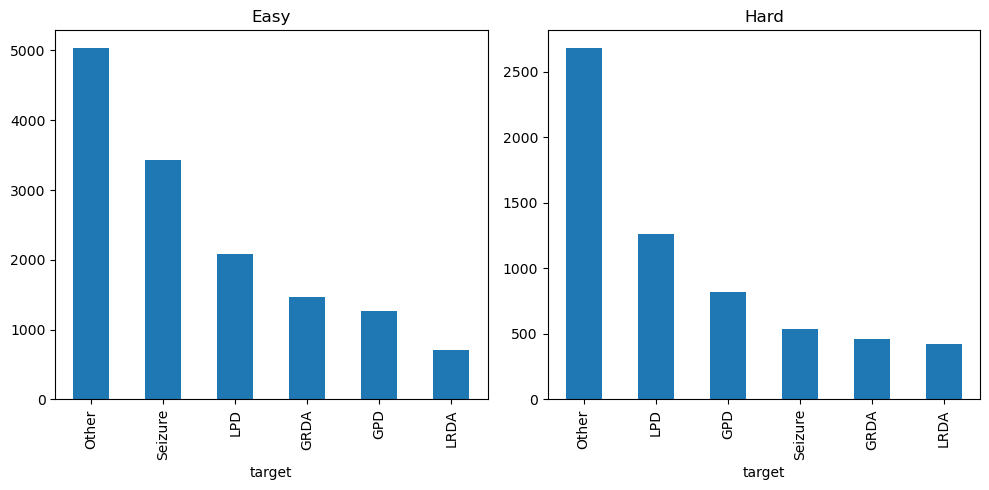

In [4]:
# check distribution of targets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
train_easy["target"].value_counts().plot(kind="bar", ax=axes[0])
train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
axes[0].set_title("Easy")
axes[1].set_title("Hard")
fig.tight_layout()
plt.show()

Hard after adding easy:  (8995, 12)


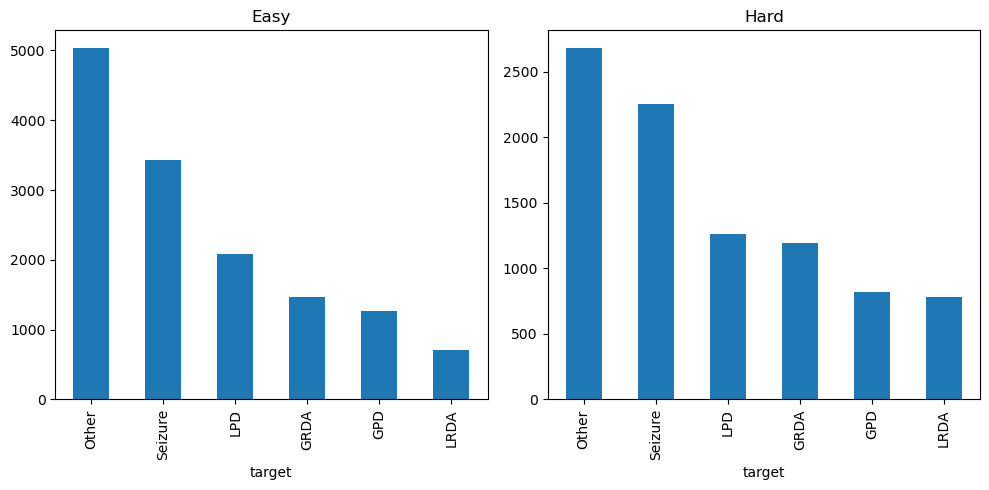

In [5]:
# Rebalance hard samples by Randomly sample from easy and add to hard.
# tgt_to_sample = ['Seizure', 'LRDA', 'GRDA']
# sample_ratio = 0.5 # 50% of easy to add to hard for each target label

# for tgt in tgt_to_sample:
#     easy_sample = train_easy[train_easy["target"] == tgt].sample(frac=sample_ratio)
#     train_hard = pd.concat([train_hard, easy_sample], axis=0)

# print("Hard after adding easy: ", train_hard.shape)

# # check distribution of targets
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# train_easy["target"].value_counts().plot(kind="bar", ax=axes[0])
# train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
# axes[0].set_title("Easy")
# axes[1].set_title("Hard")
# fig.tight_layout()
# plt.show()

In [6]:
# Config EfficientNet 
ModelConfig.EPOCHS = 6
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 2
ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
ModelConfig.MODEL_NAME = "ENet_b2_xymask_rebalance"
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENT = True
ModelConfig.AUGMENTATIONS = ['xy_masking']

hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

****************************************************************************************************
Script Start: Sat Mar 16 13:23:15 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: ENet_b2_xymask_rebalance
MODEL_BACKBONE: tf_efficientnet_b2
BATCH_SIZE: 16
EPOCHS: 6
GRADIENT_ACCUMULATION_STEPS: 2
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: True
AUGMENTATIONS: ['xy_masking']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
****************************************************************************************************


In [7]:
# # Config ViTMAE
# ModelConfig.EPOCHS = 6
# ModelConfig.MODEL_BACKBONE = 'vit_mae_base'
# ModelConfig.MODEL_NAME = "ViTMAE_base_mlp_dropout_020"
# ModelConfig.AUGMENT = True
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENTATIONS = ['xy_masking']
# ModelConfig.MAE_PRETRAINED_WEIGHTS = "./outputs/vit_mae_pretraining/ViTMAE_PreTrained_Best.pth"
# ModelConfig.MAE_HIDDEN_DROPOUT_PROB = 0.1
# ModelConfig.MAE_ATTENTION_DROPOUT_PROB = 0.1
# ModelConfig.DROP_RATE = 0.2

# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [8]:
hms_predictor.train_model(train_easy, train_hard, all_specs, all_eegs)

Train Easy: (13996, 12) | Train Hard: (8995, 12)
Fold: 0 || Valid size 7795 
- First Stage 


Train [0]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 1 [0/566] | Train Loss: 0.8913 Grad: 82335.9375 LR: 4.0000e-06 | Elapse: 1.11s
Epoch 1 [50/566] | Train Loss: 0.8325 Grad: 89566.4062 LR: 5.2855e-06 | Elapse: 9.01s
Epoch 1 [100/566] | Train Loss: 0.8112 Grad: 66099.8438 LR: 9.0731e-06 | Elapse: 16.89s
Epoch 1 [150/566] | Train Loss: 0.8221 Grad: 66461.1172 LR: 1.5160e-05 | Elapse: 24.76s
Epoch 1 [200/566] | Train Loss: 0.7971 Grad: 66164.1562 LR: 2.3220e-05 | Elapse: 32.64s
Epoch 1 [250/566] | Train Loss: 0.6789 Grad: 84561.7812 LR: 3.2822e-05 | Elapse: 40.52s
Epoch 1 [300/566] | Train Loss: 0.6268 Grad: 82354.3203 LR: 4.3451e-05 | Elapse: 48.41s
Epoch 1 [350/566] | Train Loss: 0.7238 Grad: 127325.7656 LR: 5.4537e-05 | Elapse: 56.34s
Epoch 1 [400/566] | Train Loss: 0.7548 Grad: 83071.8359 LR: 6.5488e-05 | Elapse: 64.24s
Epoch 1 [450/566] | Train Loss: 0.6783 Grad: 65331.4531 LR: 7.5717e-05 | Elapse: 72.16s
Epoch 1 [500/566] | Train Loss: 0.4390 Grad: 46140.0039 LR: 8.4675e-05 | Elapse: 80.08s
Epoch 1 [550/566] | Train Loss: 0.50

Valid [0]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 1 [0/488] | Valid Loss: 0.5106 | Elapse: 0.07s
Epoch 1 [50/488] | Valid Loss: 0.3884 | Elapse: 3.27s
Epoch 1 [100/488] | Valid Loss: 0.5399 | Elapse: 6.46s
Epoch 1 [150/488] | Valid Loss: 0.7148 | Elapse: 9.68s
Epoch 1 [200/488] | Valid Loss: 0.5488 | Elapse: 12.91s
Epoch 1 [250/488] | Valid Loss: 0.5365 | Elapse: 16.12s
Epoch 1 [300/488] | Valid Loss: 0.4644 | Elapse: 19.35s
Epoch 1 [350/488] | Valid Loss: 0.3047 | Elapse: 22.55s
Epoch 1 [400/488] | Valid Loss: 0.2881 | Elapse: 25.76s
Epoch 1 [450/488] | Valid Loss: 0.3552 | Elapse: 28.97s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6882; (valid) 0.4550 | Time: 121.80s
Best model found in epoch 1 | valid loss: 0.4550


Epoch 1 [487/488] | Valid Loss: 0.9957 | Elapse: 31.40s


Train [1]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 2 [0/566] | Train Loss: 0.6059 Grad: 149768.1562 LR: 9.3754e-05 | Elapse: 0.16s
Epoch 2 [50/566] | Train Loss: 0.4537 Grad: 64932.8789 LR: 9.8078e-05 | Elapse: 8.12s
Epoch 2 [100/566] | Train Loss: 0.3519 Grad: 31865.7969 LR: 9.9935e-05 | Elapse: 16.10s
Epoch 2 [150/566] | Train Loss: 0.3938 Grad: 43635.2578 LR: 9.9990e-05 | Elapse: 24.09s
Epoch 2 [200/566] | Train Loss: 0.2518 Grad: 23865.8027 LR: 9.9948e-05 | Elapse: 32.08s
Epoch 2 [250/566] | Train Loss: 0.5095 Grad: 44664.7227 LR: 9.9873e-05 | Elapse: 40.08s
Epoch 2 [300/566] | Train Loss: 0.3001 Grad: 29023.5000 LR: 9.9765e-05 | Elapse: 48.09s
Epoch 2 [350/566] | Train Loss: 0.4370 Grad: 36423.5195 LR: 9.9624e-05 | Elapse: 56.10s
Epoch 2 [400/566] | Train Loss: 0.3200 Grad: 23878.5391 LR: 9.9450e-05 | Elapse: 64.12s
Epoch 2 [450/566] | Train Loss: 0.4966 Grad: 50979.8477 LR: 9.9244e-05 | Elapse: 72.14s
Epoch 2 [500/566] | Train Loss: 0.2864 Grad: 42927.0234 LR: 9.9006e-05 | Elapse: 80.16s
Epoch 2 [550/566] | Train Loss: 0.34

Valid [1]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2 [0/488] | Valid Loss: 0.3828 | Elapse: 0.07s
Epoch 2 [50/488] | Valid Loss: 0.1830 | Elapse: 3.28s
Epoch 2 [100/488] | Valid Loss: 0.3860 | Elapse: 6.56s
Epoch 2 [150/488] | Valid Loss: 0.6098 | Elapse: 9.78s
Epoch 2 [200/488] | Valid Loss: 0.3175 | Elapse: 13.02s
Epoch 2 [250/488] | Valid Loss: 0.3466 | Elapse: 16.24s
Epoch 2 [300/488] | Valid Loss: 0.2362 | Elapse: 19.47s
Epoch 2 [350/488] | Valid Loss: 0.2688 | Elapse: 22.73s
Epoch 2 [400/488] | Valid Loss: 0.2640 | Elapse: 25.96s
Epoch 2 [450/488] | Valid Loss: 0.2898 | Elapse: 29.19s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4196; (valid) 0.3544 | Time: 122.11s
Best model found in epoch 2 | valid loss: 0.3544


Epoch 2 [487/488] | Valid Loss: 0.5724 | Elapse: 31.53s


Train [2]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 3 [0/566] | Train Loss: 0.3597 Grad: 157367.9375 LR: 9.8641e-05 | Elapse: 0.16s
Epoch 3 [50/566] | Train Loss: 0.3435 Grad: 68304.5078 LR: 9.8327e-05 | Elapse: 8.15s
Epoch 3 [100/566] | Train Loss: 0.3323 Grad: 66477.5625 LR: 9.7982e-05 | Elapse: 16.15s
Epoch 3 [150/566] | Train Loss: 0.3035 Grad: 87906.1172 LR: 9.7605e-05 | Elapse: 24.15s
Epoch 3 [200/566] | Train Loss: 0.1514 Grad: 23094.6523 LR: 9.7197e-05 | Elapse: 32.18s
Epoch 3 [250/566] | Train Loss: 0.4212 Grad: 44004.7148 LR: 9.6757e-05 | Elapse: 40.21s
Epoch 3 [300/566] | Train Loss: 0.1772 Grad: 27787.3301 LR: 9.6286e-05 | Elapse: 48.23s
Epoch 3 [350/566] | Train Loss: 0.3567 Grad: 45284.0469 LR: 9.5785e-05 | Elapse: 56.24s
Epoch 3 [400/566] | Train Loss: 0.3003 Grad: 43936.4766 LR: 9.5254e-05 | Elapse: 64.25s
Epoch 3 [450/566] | Train Loss: 0.3639 Grad: 46654.4375 LR: 9.4693e-05 | Elapse: 72.27s
Epoch 3 [500/566] | Train Loss: 0.2599 Grad: 39178.6875 LR: 9.4102e-05 | Elapse: 80.27s
Epoch 3 [550/566] | Train Loss: 0.35

Valid [2]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3 [0/488] | Valid Loss: 0.3243 | Elapse: 0.07s
Epoch 3 [50/488] | Valid Loss: 0.1559 | Elapse: 3.28s
Epoch 3 [100/488] | Valid Loss: 0.3124 | Elapse: 6.48s
Epoch 3 [150/488] | Valid Loss: 0.5540 | Elapse: 9.69s
Epoch 3 [200/488] | Valid Loss: 0.2643 | Elapse: 12.91s
Epoch 3 [250/488] | Valid Loss: 0.3259 | Elapse: 16.13s
Epoch 3 [300/488] | Valid Loss: 0.1601 | Elapse: 19.35s
Epoch 3 [350/488] | Valid Loss: 0.2832 | Elapse: 22.56s
Epoch 3 [400/488] | Valid Loss: 0.2922 | Elapse: 25.76s
Epoch 3 [450/488] | Valid Loss: 0.3134 | Elapse: 28.98s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3304; (valid) 0.3520 | Time: 122.00s
Best model found in epoch 3 | valid loss: 0.3520


Epoch 3 [487/488] | Valid Loss: 0.3596 | Elapse: 31.32s


Train [3]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 4 [0/566] | Train Loss: 0.3308 Grad: 163572.5000 LR: 9.3278e-05 | Elapse: 0.16s
Epoch 4 [50/566] | Train Loss: 0.2782 Grad: 35620.8828 LR: 9.2621e-05 | Elapse: 8.13s
Epoch 4 [100/566] | Train Loss: 0.2849 Grad: 38602.8711 LR: 9.1935e-05 | Elapse: 16.15s
Epoch 4 [150/566] | Train Loss: 0.2584 Grad: 43066.6523 LR: 9.1222e-05 | Elapse: 24.18s
Epoch 4 [200/566] | Train Loss: 0.1618 Grad: 33835.0742 LR: 9.0481e-05 | Elapse: 32.21s
Epoch 4 [250/566] | Train Loss: 0.3240 Grad: 50736.3516 LR: 8.9714e-05 | Elapse: 40.25s
Epoch 4 [300/566] | Train Loss: 0.1366 Grad: 25654.6211 LR: 8.8921e-05 | Elapse: 48.28s
Epoch 4 [350/566] | Train Loss: 0.2823 Grad: 47347.9883 LR: 8.8101e-05 | Elapse: 56.31s
Epoch 4 [400/566] | Train Loss: 0.3083 Grad: 41606.1484 LR: 8.7257e-05 | Elapse: 64.34s
Epoch 4 [450/566] | Train Loss: 0.2627 Grad: 36289.0391 LR: 8.6388e-05 | Elapse: 72.36s
Epoch 4 [500/566] | Train Loss: 0.2472 Grad: 49802.9766 LR: 8.5495e-05 | Elapse: 80.41s
Epoch 4 [550/566] | Train Loss: 0.20

Valid [3]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4 [0/488] | Valid Loss: 0.3163 | Elapse: 0.07s
Epoch 4 [50/488] | Valid Loss: 0.1371 | Elapse: 3.28s
Epoch 4 [100/488] | Valid Loss: 0.2781 | Elapse: 6.48s
Epoch 4 [150/488] | Valid Loss: 0.4795 | Elapse: 9.69s
Epoch 4 [200/488] | Valid Loss: 0.2688 | Elapse: 12.91s
Epoch 4 [250/488] | Valid Loss: 0.2888 | Elapse: 16.13s
Epoch 4 [300/488] | Valid Loss: 0.1622 | Elapse: 19.36s
Epoch 4 [350/488] | Valid Loss: 0.2858 | Elapse: 22.57s
Epoch 4 [400/488] | Valid Loss: 0.2643 | Elapse: 25.79s
Epoch 4 [450/488] | Valid Loss: 0.3328 | Elapse: 29.01s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2792; (valid) 0.3417 | Time: 122.20s
Best model found in epoch 4 | valid loss: 0.3417


Epoch 4 [487/488] | Valid Loss: 0.2851 | Elapse: 31.35s


Train [4]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 5 [0/566] | Train Loss: 0.2535 Grad: nan LR: 8.4281e-05 | Elapse: 0.16s
Epoch 5 [50/566] | Train Loss: 0.2384 Grad: 37583.6367 LR: 8.3335e-05 | Elapse: 8.17s
Epoch 5 [100/566] | Train Loss: 0.2082 Grad: 33464.0625 LR: 8.2366e-05 | Elapse: 16.19s
Epoch 5 [150/566] | Train Loss: 0.2070 Grad: 81590.2344 LR: 8.1377e-05 | Elapse: 24.26s
Epoch 5 [200/566] | Train Loss: 0.1010 Grad: 25909.6152 LR: 8.0366e-05 | Elapse: 32.32s
Epoch 5 [250/566] | Train Loss: 0.2900 Grad: 35199.9727 LR: 7.9336e-05 | Elapse: 40.39s
Epoch 5 [300/566] | Train Loss: 0.0907 Grad: 24233.6562 LR: 7.8286e-05 | Elapse: 48.45s
Epoch 5 [350/566] | Train Loss: 0.2505 Grad: 56628.5547 LR: 7.7218e-05 | Elapse: 56.48s
Epoch 5 [400/566] | Train Loss: 0.1821 Grad: 55883.4766 LR: 7.6131e-05 | Elapse: 64.50s
Epoch 5 [450/566] | Train Loss: 0.3038 Grad: 50045.4609 LR: 7.5028e-05 | Elapse: 72.52s
Epoch 5 [500/566] | Train Loss: 0.1907 Grad: 43528.5742 LR: 7.3908e-05 | Elapse: 80.53s
Epoch 5 [550/566] | Train Loss: 0.2162 Grad:

Valid [4]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5 [0/488] | Valid Loss: 0.2914 | Elapse: 0.07s
Epoch 5 [50/488] | Valid Loss: 0.1565 | Elapse: 3.28s
Epoch 5 [100/488] | Valid Loss: 0.2604 | Elapse: 6.48s
Epoch 5 [150/488] | Valid Loss: 0.4571 | Elapse: 9.69s
Epoch 5 [200/488] | Valid Loss: 0.2296 | Elapse: 12.92s
Epoch 5 [250/488] | Valid Loss: 0.3006 | Elapse: 16.19s
Epoch 5 [300/488] | Valid Loss: 0.1233 | Elapse: 19.45s
Epoch 5 [350/488] | Valid Loss: 0.3082 | Elapse: 22.71s
Epoch 5 [400/488] | Valid Loss: 0.2814 | Elapse: 25.96s
Epoch 5 [450/488] | Valid Loss: 0.3503 | Elapse: 29.22s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2314; (valid) 0.3582 | Time: 122.54s


Epoch 5 [487/488] | Valid Loss: 0.1956 | Elapse: 31.59s


Train [5]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 6 [0/566] | Train Loss: 0.2969 Grad: nan LR: 7.2405e-05 | Elapse: 0.16s
Epoch 6 [50/566] | Train Loss: 0.2730 Grad: 51985.2578 LR: 7.1249e-05 | Elapse: 8.18s
Epoch 6 [100/566] | Train Loss: 0.2281 Grad: 32296.6934 LR: 7.0080e-05 | Elapse: 16.20s
Epoch 6 [150/566] | Train Loss: 0.1550 Grad: 47894.1094 LR: 6.8897e-05 | Elapse: 24.25s
Epoch 6 [200/566] | Train Loss: 0.1654 Grad: 57566.4297 LR: 6.7702e-05 | Elapse: 32.31s
Epoch 6 [250/566] | Train Loss: 0.3377 Grad: 65653.2422 LR: 6.6495e-05 | Elapse: 40.39s
Epoch 6 [300/566] | Train Loss: 0.1062 Grad: 35192.7266 LR: 6.5277e-05 | Elapse: 48.45s
Epoch 6 [350/566] | Train Loss: 0.1483 Grad: 46057.5742 LR: 6.4049e-05 | Elapse: 56.51s
Epoch 6 [400/566] | Train Loss: 0.2272 Grad: 55896.4102 LR: 6.2812e-05 | Elapse: 64.59s
Epoch 6 [450/566] | Train Loss: 0.2129 Grad: 48980.0586 LR: 6.1566e-05 | Elapse: 72.65s
Epoch 6 [500/566] | Train Loss: 0.1785 Grad: 54125.6523 LR: 6.0313e-05 | Elapse: 80.74s
Epoch 6 [550/566] | Train Loss: 0.1400 Grad:

Valid [5]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 6 [0/488] | Valid Loss: 0.2978 | Elapse: 0.08s
Epoch 6 [50/488] | Valid Loss: 0.1681 | Elapse: 3.36s
Epoch 6 [100/488] | Valid Loss: 0.2548 | Elapse: 6.62s
Epoch 6 [150/488] | Valid Loss: 0.5272 | Elapse: 9.88s
Epoch 6 [200/488] | Valid Loss: 0.2377 | Elapse: 13.14s
Epoch 6 [250/488] | Valid Loss: 0.3126 | Elapse: 16.43s
Epoch 6 [300/488] | Valid Loss: 0.1408 | Elapse: 19.70s
Epoch 6 [350/488] | Valid Loss: 0.3443 | Elapse: 22.96s
Epoch 6 [400/488] | Valid Loss: 0.2799 | Elapse: 26.23s
Epoch 6 [450/488] | Valid Loss: 0.4342 | Elapse: 29.49s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1998; (valid) 0.3649 | Time: 123.13s


Epoch 6 [487/488] | Valid Loss: 0.2306 | Elapse: 31.86s


Fold 0 Valid Loss: (Easy) 0.6493 | (Hard) 0.7421
Elapse: 12.25 min 
- Second Stage 
Use Checkpoint: ENet_b2_xymask_rebalance_fold_0_stage_1.pth


Train [0]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 1 [0/383] | Train Loss: 0.5488 Grad: nan LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/383] | Train Loss: 0.4195 Grad: 39475.5977 LR: 6.8003e-06 | Elapse: 8.19s
Epoch 1 [100/383] | Train Loss: 0.4410 Grad: 31079.3691 LR: 1.4875e-05 | Elapse: 16.23s
Epoch 1 [150/383] | Train Loss: 0.2816 Grad: 22473.8320 LR: 2.7281e-05 | Elapse: 24.30s
Epoch 1 [200/383] | Train Loss: 0.3105 Grad: 23064.7305 LR: 4.2571e-05 | Elapse: 32.45s
Epoch 1 [250/383] | Train Loss: 0.8686 Grad: 29238.9590 LR: 5.8962e-05 | Elapse: 40.58s
Epoch 1 [300/383] | Train Loss: 0.1417 Grad: 8220.7109 LR: 7.4540e-05 | Elapse: 48.66s
Epoch 1 [350/383] | Train Loss: 1.2154 Grad: 20006.3750 LR: 8.7488e-05 | Elapse: 56.74s
Epoch 1 [382/383] | Train Loss: 0.4270 Grad: 8732.3721 LR: 9.3679e-05 | Elapse: 61.91s


Valid [0]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 1 [0/488] | Valid Loss: 0.6772 | Elapse: 0.07s
Epoch 1 [50/488] | Valid Loss: 0.6300 | Elapse: 3.37s
Epoch 1 [100/488] | Valid Loss: 0.6021 | Elapse: 6.64s
Epoch 1 [150/488] | Valid Loss: 0.7235 | Elapse: 9.92s
Epoch 1 [200/488] | Valid Loss: 0.6864 | Elapse: 13.20s
Epoch 1 [250/488] | Valid Loss: 0.6938 | Elapse: 16.48s
Epoch 1 [300/488] | Valid Loss: 0.7293 | Elapse: 19.76s
Epoch 1 [350/488] | Valid Loss: 0.4137 | Elapse: 23.02s
Epoch 1 [400/488] | Valid Loss: 0.4688 | Elapse: 26.30s
Epoch 1 [450/488] | Valid Loss: 0.4119 | Elapse: 29.57s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5072; (valid) 0.6148 | Time: 93.87s
Best model found in epoch 1 | valid loss: 0.6148


Epoch 1 [487/488] | Valid Loss: 0.4419 | Elapse: 31.96s


Train [1]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 2 [0/383] | Train Loss: 0.5380 Grad: 83634.5391 LR: 9.3679e-05 | Elapse: 0.17s
Epoch 2 [50/383] | Train Loss: 0.3619 Grad: 74522.3750 LR: 9.9261e-05 | Elapse: 8.23s
Epoch 2 [100/383] | Train Loss: 0.3230 Grad: 75224.2578 LR: 9.9991e-05 | Elapse: 16.29s
Epoch 2 [150/383] | Train Loss: 0.2042 Grad: 78994.4219 LR: 9.9920e-05 | Elapse: 24.35s
Epoch 2 [200/383] | Train Loss: 0.2551 Grad: 88347.1641 LR: 9.9777e-05 | Elapse: 32.45s
Epoch 2 [250/383] | Train Loss: 0.6469 Grad: 104149.9375 LR: 9.9562e-05 | Elapse: 40.53s
Epoch 2 [300/383] | Train Loss: 0.1318 Grad: 56459.1875 LR: 9.9276e-05 | Elapse: 48.64s
Epoch 2 [350/383] | Train Loss: 1.1024 Grad: 92365.9844 LR: 9.8919e-05 | Elapse: 56.74s
Epoch 2 [382/383] | Train Loss: 0.2613 Grad: 15521.2705 LR: 9.8653e-05 | Elapse: 61.91s


Valid [1]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2 [0/488] | Valid Loss: 0.6890 | Elapse: 0.08s
Epoch 2 [50/488] | Valid Loss: 0.6765 | Elapse: 3.35s
Epoch 2 [100/488] | Valid Loss: 0.6212 | Elapse: 6.61s
Epoch 2 [150/488] | Valid Loss: 0.7908 | Elapse: 9.88s
Epoch 2 [200/488] | Valid Loss: 0.6267 | Elapse: 13.16s
Epoch 2 [250/488] | Valid Loss: 0.8079 | Elapse: 16.43s
Epoch 2 [300/488] | Valid Loss: 0.6822 | Elapse: 19.71s
Epoch 2 [350/488] | Valid Loss: 0.5076 | Elapse: 22.98s
Epoch 2 [400/488] | Valid Loss: 0.5863 | Elapse: 26.24s
Epoch 2 [450/488] | Valid Loss: 0.5075 | Elapse: 29.51s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4278; (valid) 0.6671 | Time: 93.81s


Epoch 2 [487/488] | Valid Loss: 0.3603 | Elapse: 31.89s


Train [2]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 3 [0/383] | Train Loss: 0.6627 Grad: inf LR: 9.8653e-05 | Elapse: 0.16s
Epoch 3 [50/383] | Train Loss: 0.2706 Grad: 30879.4395 LR: 9.8180e-05 | Elapse: 8.22s
Epoch 3 [100/383] | Train Loss: 0.2940 Grad: 47724.6172 LR: 9.7638e-05 | Elapse: 16.29s
Epoch 3 [150/383] | Train Loss: 0.2242 Grad: 36933.1914 LR: 9.7027e-05 | Elapse: 24.37s
Epoch 3 [200/383] | Train Loss: 0.2284 Grad: 42692.9219 LR: 9.6349e-05 | Elapse: 32.46s
Epoch 3 [250/383] | Train Loss: 0.5525 Grad: 44435.2188 LR: 9.5603e-05 | Elapse: 40.56s
Epoch 3 [300/383] | Train Loss: 0.1462 Grad: 20106.8320 LR: 9.4792e-05 | Elapse: 48.67s
Epoch 3 [350/383] | Train Loss: 1.0619 Grad: 92494.2422 LR: 9.3917e-05 | Elapse: 56.79s
Epoch 3 [382/383] | Train Loss: 0.4389 Grad: 56242.2422 LR: 9.3323e-05 | Elapse: 61.97s


Valid [2]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3 [0/488] | Valid Loss: 0.6271 | Elapse: 0.07s
Epoch 3 [50/488] | Valid Loss: 0.5997 | Elapse: 3.34s
Epoch 3 [100/488] | Valid Loss: 0.4762 | Elapse: 6.60s
Epoch 3 [150/488] | Valid Loss: 0.6981 | Elapse: 9.89s
Epoch 3 [200/488] | Valid Loss: 0.6506 | Elapse: 13.16s
Epoch 3 [250/488] | Valid Loss: 0.6237 | Elapse: 16.44s
Epoch 3 [300/488] | Valid Loss: 0.5968 | Elapse: 19.72s
Epoch 3 [350/488] | Valid Loss: 0.4534 | Elapse: 23.00s
Epoch 3 [400/488] | Valid Loss: 0.5331 | Elapse: 26.27s
Epoch 3 [450/488] | Valid Loss: 0.3904 | Elapse: 29.54s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4053; (valid) 0.5907 | Time: 93.90s
Best model found in epoch 3 | valid loss: 0.5907


Epoch 3 [487/488] | Valid Loss: 0.5022 | Elapse: 31.92s


Train [3]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 4 [0/383] | Train Loss: 0.4990 Grad: 126185.3203 LR: 9.3323e-05 | Elapse: 0.16s
Epoch 4 [50/383] | Train Loss: 0.2715 Grad: 81492.8047 LR: 9.2344e-05 | Elapse: 8.20s
Epoch 4 [100/383] | Train Loss: 0.2650 Grad: 128021.0625 LR: 9.1304e-05 | Elapse: 16.24s
Epoch 4 [150/383] | Train Loss: 0.1791 Grad: 56599.0195 LR: 9.0205e-05 | Elapse: 24.33s
Epoch 4 [200/383] | Train Loss: 0.2185 Grad: 35827.4102 LR: 8.9048e-05 | Elapse: 32.42s
Epoch 4 [250/383] | Train Loss: 0.5527 Grad: 47969.9570 LR: 8.7834e-05 | Elapse: 40.52s
Epoch 4 [300/383] | Train Loss: 0.1477 Grad: 13025.3223 LR: 8.6566e-05 | Elapse: 48.64s
Epoch 4 [350/383] | Train Loss: 0.9588 Grad: 30189.5625 LR: 8.5246e-05 | Elapse: 56.74s
Epoch 4 [382/383] | Train Loss: 0.5366 Grad: 19498.5547 LR: 8.4374e-05 | Elapse: 61.90s


Valid [3]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4 [0/488] | Valid Loss: 0.5718 | Elapse: 0.07s
Epoch 4 [50/488] | Valid Loss: 0.4605 | Elapse: 3.35s
Epoch 4 [100/488] | Valid Loss: 0.4374 | Elapse: 6.61s
Epoch 4 [150/488] | Valid Loss: 0.6777 | Elapse: 9.87s
Epoch 4 [200/488] | Valid Loss: 0.5230 | Elapse: 13.15s
Epoch 4 [250/488] | Valid Loss: 0.4967 | Elapse: 16.43s
Epoch 4 [300/488] | Valid Loss: 0.5270 | Elapse: 19.71s
Epoch 4 [350/488] | Valid Loss: 0.3537 | Elapse: 22.98s
Epoch 4 [400/488] | Valid Loss: 0.3709 | Elapse: 26.24s
Epoch 4 [450/488] | Valid Loss: 0.3130 | Elapse: 29.51s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3710; (valid) 0.4800 | Time: 93.79s
Best model found in epoch 4 | valid loss: 0.4800


Epoch 4 [487/488] | Valid Loss: 0.6104 | Elapse: 31.89s


Train [4]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 5 [0/383] | Train Loss: 0.3343 Grad: 107834.7500 LR: 8.4374e-05 | Elapse: 0.16s
Epoch 5 [50/383] | Train Loss: 0.2496 Grad: 33378.3438 LR: 8.2971e-05 | Elapse: 8.19s
Epoch 5 [100/383] | Train Loss: 0.2203 Grad: 37532.3008 LR: 8.1520e-05 | Elapse: 16.22s
Epoch 5 [150/383] | Train Loss: 0.1629 Grad: 26648.2598 LR: 8.0024e-05 | Elapse: 24.28s
Epoch 5 [200/383] | Train Loss: 0.1805 Grad: 41936.2891 LR: 7.8485e-05 | Elapse: 32.37s
Epoch 5 [250/383] | Train Loss: 0.4463 Grad: 47182.9258 LR: 7.6905e-05 | Elapse: 40.42s
Epoch 5 [300/383] | Train Loss: 0.1408 Grad: 24669.1465 LR: 7.5286e-05 | Elapse: 48.51s
Epoch 5 [350/383] | Train Loss: 0.9302 Grad: 45433.2500 LR: 7.3630e-05 | Elapse: 56.57s
Epoch 5 [382/383] | Train Loss: 0.4881 Grad: 21311.6562 LR: 7.2553e-05 | Elapse: 61.72s


Valid [4]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5 [0/488] | Valid Loss: 0.5353 | Elapse: 0.07s
Epoch 5 [50/488] | Valid Loss: 0.4536 | Elapse: 3.34s
Epoch 5 [100/488] | Valid Loss: 0.4068 | Elapse: 6.59s
Epoch 5 [150/488] | Valid Loss: 0.6656 | Elapse: 9.88s
Epoch 5 [200/488] | Valid Loss: 0.4931 | Elapse: 13.17s
Epoch 5 [250/488] | Valid Loss: 0.4890 | Elapse: 16.45s
Epoch 5 [300/488] | Valid Loss: 0.5508 | Elapse: 19.73s
Epoch 5 [350/488] | Valid Loss: 0.4108 | Elapse: 22.99s
Epoch 5 [400/488] | Valid Loss: 0.3778 | Elapse: 26.25s
Epoch 5 [450/488] | Valid Loss: 0.3229 | Elapse: 29.52s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3409; (valid) 0.4801 | Time: 93.65s


Epoch 5 [487/488] | Valid Loss: 0.5371 | Elapse: 31.92s


Train [5]:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 6 [0/383] | Train Loss: 0.3741 Grad: 156289.1875 LR: 7.2553e-05 | Elapse: 0.17s
Epoch 6 [50/383] | Train Loss: 0.2262 Grad: 34747.8086 LR: 7.0843e-05 | Elapse: 8.19s
Epoch 6 [100/383] | Train Loss: 0.2158 Grad: 45870.0430 LR: 6.9103e-05 | Elapse: 16.22s
Epoch 6 [150/383] | Train Loss: 0.1994 Grad: 31781.3926 LR: 6.7335e-05 | Elapse: 24.29s
Epoch 6 [200/383] | Train Loss: 0.2044 Grad: 33819.4766 LR: 6.5543e-05 | Elapse: 32.37s
Epoch 6 [250/383] | Train Loss: 0.3902 Grad: 35067.5742 LR: 6.3728e-05 | Elapse: 40.46s
Epoch 6 [300/383] | Train Loss: 0.1194 Grad: 9902.1338 LR: 6.1893e-05 | Elapse: 48.57s
Epoch 6 [350/383] | Train Loss: 0.8443 Grad: 41122.9023 LR: 6.0041e-05 | Elapse: 56.65s
Epoch 6 [382/383] | Train Loss: 0.4045 Grad: 11590.5000 LR: 5.8848e-05 | Elapse: 61.80s


Valid [5]:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 6 [0/488] | Valid Loss: 0.4710 | Elapse: 0.07s
Epoch 6 [50/488] | Valid Loss: 0.3971 | Elapse: 3.34s
Epoch 6 [100/488] | Valid Loss: 0.3483 | Elapse: 6.60s
Epoch 6 [150/488] | Valid Loss: 0.6376 | Elapse: 9.87s
Epoch 6 [200/488] | Valid Loss: 0.4739 | Elapse: 13.16s
Epoch 6 [250/488] | Valid Loss: 0.4497 | Elapse: 16.44s
Epoch 6 [300/488] | Valid Loss: 0.4788 | Elapse: 19.72s
Epoch 6 [350/488] | Valid Loss: 0.3789 | Elapse: 22.99s
Epoch 6 [400/488] | Valid Loss: 0.3465 | Elapse: 26.27s
Epoch 6 [450/488] | Valid Loss: 0.2800 | Elapse: 29.55s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3153; (valid) 0.4438 | Time: 93.73s
Best model found in epoch 6 | valid loss: 0.4438


Epoch 6 [487/488] | Valid Loss: 0.5760 | Elapse: 31.93s


Fold 0 Valid Loss: (Easy) 0.9838 | (Hard) 0.7218
Elapse: 9.39 min 
Fold: 1 || Valid size 4711 
- First Stage 


Train [0]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 1 [0/688] | Train Loss: 0.8409 Grad: 71220.0000 LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/688] | Train Loss: 0.8025 Grad: 81704.2656 LR: 4.8704e-06 | Elapse: 8.18s
Epoch 1 [100/688] | Train Loss: 0.7881 Grad: 64925.7461 LR: 7.4499e-06 | Elapse: 16.20s
Epoch 1 [150/688] | Train Loss: 0.7712 Grad: 60367.9180 LR: 1.1645e-05 | Elapse: 24.25s
Epoch 1 [200/688] | Train Loss: 0.7887 Grad: 67073.4844 LR: 1.7304e-05 | Elapse: 32.32s
Epoch 1 [250/688] | Train Loss: 0.7668 Grad: 64851.9727 LR: 2.4221e-05 | Elapse: 40.40s
Epoch 1 [300/688] | Train Loss: 0.7195 Grad: 72263.7500 LR: 3.2145e-05 | Elapse: 48.46s
Epoch 1 [350/688] | Train Loss: 0.6017 Grad: 60503.9531 LR: 4.0789e-05 | Elapse: 56.51s
Epoch 1 [400/688] | Train Loss: 0.5964 Grad: 82935.5547 LR: 4.9840e-05 | Elapse: 64.55s
Epoch 1 [450/688] | Train Loss: 0.4793 Grad: 82125.9062 LR: 5.8969e-05 | Elapse: 72.61s
Epoch 1 [500/688] | Train Loss: 0.5686 Grad: 82534.2578 LR: 6.7846e-05 | Elapse: 80.66s
Epoch 1 [550/688] | Train Loss: 0.515

Valid [0]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 1 [0/295] | Valid Loss: 0.5366 | Elapse: 0.07s
Epoch 1 [50/295] | Valid Loss: 0.3317 | Elapse: 3.32s
Epoch 1 [100/295] | Valid Loss: 0.2861 | Elapse: 6.56s
Epoch 1 [150/295] | Valid Loss: 0.2753 | Elapse: 9.81s
Epoch 1 [200/295] | Valid Loss: 0.3484 | Elapse: 13.07s
Epoch 1 [250/295] | Valid Loss: 0.3468 | Elapse: 16.32s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6679; (valid) 0.3798 | Time: 130.08s
Best model found in epoch 1 | valid loss: 0.3798


Epoch 1 [294/295] | Valid Loss: 0.5705 | Elapse: 19.24s


Train [1]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 2 [0/688] | Train Loss: 0.4399 Grad: 172080.5781 LR: 9.3721e-05 | Elapse: 0.17s
Epoch 2 [50/688] | Train Loss: 0.4818 Grad: 50891.2070 LR: 9.7464e-05 | Elapse: 8.18s
Epoch 2 [100/688] | Train Loss: 0.4417 Grad: 54731.5234 LR: 9.9558e-05 | Elapse: 16.22s
Epoch 2 [150/688] | Train Loss: 0.4900 Grad: 38331.9492 LR: 9.9999e-05 | Elapse: 24.29s
Epoch 2 [200/688] | Train Loss: 0.4112 Grad: 58304.0430 LR: 9.9981e-05 | Elapse: 32.36s
Epoch 2 [250/688] | Train Loss: 0.3914 Grad: 28676.3301 LR: 9.9942e-05 | Elapse: 40.43s
Epoch 2 [300/688] | Train Loss: 0.5258 Grad: 48519.9141 LR: 9.9879e-05 | Elapse: 48.48s
Epoch 2 [350/688] | Train Loss: 0.2606 Grad: 38528.5703 LR: 9.9795e-05 | Elapse: 56.55s
Epoch 2 [400/688] | Train Loss: 0.3170 Grad: 34395.2383 LR: 9.9688e-05 | Elapse: 64.59s
Epoch 2 [450/688] | Train Loss: 0.2413 Grad: 42293.6797 LR: 9.9559e-05 | Elapse: 72.65s
Epoch 2 [500/688] | Train Loss: 0.5112 Grad: 32763.4258 LR: 9.9408e-05 | Elapse: 80.70s
Epoch 2 [550/688] | Train Loss: 0.39

Valid [1]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 2 [0/295] | Valid Loss: 0.4111 | Elapse: 0.08s
Epoch 2 [50/295] | Valid Loss: 0.3360 | Elapse: 3.32s
Epoch 2 [100/295] | Valid Loss: 0.2497 | Elapse: 6.57s
Epoch 2 [150/295] | Valid Loss: 0.2364 | Elapse: 9.82s
Epoch 2 [200/295] | Valid Loss: 0.3966 | Elapse: 13.09s
Epoch 2 [250/295] | Valid Loss: 0.4789 | Elapse: 16.35s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3992; (valid) 0.3329 | Time: 130.00s
Best model found in epoch 2 | valid loss: 0.3329


Epoch 2 [294/295] | Valid Loss: 0.2357 | Elapse: 19.19s


Train [2]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 3 [0/688] | Train Loss: 0.3121 Grad: 135267.0312 LR: 9.8643e-05 | Elapse: 0.17s
Epoch 3 [50/688] | Train Loss: 0.2683 Grad: 36894.7422 LR: 9.8388e-05 | Elapse: 8.18s
Epoch 3 [100/688] | Train Loss: 0.3230 Grad: 37597.2109 LR: 9.8111e-05 | Elapse: 16.22s
Epoch 3 [150/688] | Train Loss: 0.3451 Grad: 51368.1094 LR: 9.7812e-05 | Elapse: 24.28s
Epoch 3 [200/688] | Train Loss: 0.2801 Grad: 36699.9570 LR: 9.7492e-05 | Elapse: 32.36s
Epoch 3 [250/688] | Train Loss: 0.3690 Grad: 34367.5039 LR: 9.7151e-05 | Elapse: 40.45s
Epoch 3 [300/688] | Train Loss: 0.4886 Grad: 42318.4727 LR: 9.6789e-05 | Elapse: 48.50s
Epoch 3 [350/688] | Train Loss: 0.2450 Grad: 33141.7852 LR: 9.6406e-05 | Elapse: 56.54s
Epoch 3 [400/688] | Train Loss: 0.2793 Grad: 50016.8867 LR: 9.6002e-05 | Elapse: 64.59s
Epoch 3 [450/688] | Train Loss: 0.1972 Grad: 42943.0859 LR: 9.5578e-05 | Elapse: 72.64s
Epoch 3 [500/688] | Train Loss: 0.3794 Grad: 34947.5508 LR: 9.5133e-05 | Elapse: 80.70s
Epoch 3 [550/688] | Train Loss: 0.32

Valid [2]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 3 [0/295] | Valid Loss: 0.3866 | Elapse: 0.07s
Epoch 3 [50/295] | Valid Loss: 0.3077 | Elapse: 3.31s
Epoch 3 [100/295] | Valid Loss: 0.2360 | Elapse: 6.55s
Epoch 3 [150/295] | Valid Loss: 0.2549 | Elapse: 9.81s
Epoch 3 [200/295] | Valid Loss: 0.3931 | Elapse: 13.06s
Epoch 3 [250/295] | Valid Loss: 0.4566 | Elapse: 16.31s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3174; (valid) 0.3139 | Time: 130.00s
Best model found in epoch 3 | valid loss: 0.3139


Epoch 3 [294/295] | Valid Loss: 0.1031 | Elapse: 19.14s


Train [3]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 4 [0/688] | Train Loss: 0.2646 Grad: inf LR: 9.3283e-05 | Elapse: 0.16s
Epoch 4 [50/688] | Train Loss: 0.2624 Grad: 34648.7891 LR: 9.2744e-05 | Elapse: 8.17s
Epoch 4 [100/688] | Train Loss: 0.3059 Grad: 54376.6172 LR: 9.2186e-05 | Elapse: 16.20s
Epoch 4 [150/688] | Train Loss: 0.3415 Grad: 35977.5117 LR: 9.1610e-05 | Elapse: 24.27s
Epoch 4 [200/688] | Train Loss: 0.1965 Grad: 35169.1484 LR: 9.1014e-05 | Elapse: 32.33s
Epoch 4 [250/688] | Train Loss: 0.3355 Grad: 49362.1562 LR: 9.0401e-05 | Elapse: 40.38s
Epoch 4 [300/688] | Train Loss: 0.4510 Grad: 54174.8789 LR: 8.9769e-05 | Elapse: 48.43s
Epoch 4 [350/688] | Train Loss: 0.1767 Grad: 42072.9375 LR: 8.9120e-05 | Elapse: 56.48s
Epoch 4 [400/688] | Train Loss: 0.2595 Grad: 54916.9570 LR: 8.8453e-05 | Elapse: 64.54s
Epoch 4 [450/688] | Train Loss: 0.1365 Grad: 22141.6895 LR: 8.7769e-05 | Elapse: 72.59s
Epoch 4 [500/688] | Train Loss: 0.2826 Grad: 35159.4375 LR: 8.7068e-05 | Elapse: 80.63s
Epoch 4 [550/688] | Train Loss: 0.2446 Grad:

Valid [3]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 4 [0/295] | Valid Loss: 0.3241 | Elapse: 0.07s
Epoch 4 [50/295] | Valid Loss: 0.2278 | Elapse: 3.32s
Epoch 4 [100/295] | Valid Loss: 0.2617 | Elapse: 6.57s
Epoch 4 [150/295] | Valid Loss: 0.1946 | Elapse: 9.83s
Epoch 4 [200/295] | Valid Loss: 0.4155 | Elapse: 13.10s
Epoch 4 [250/295] | Valid Loss: 0.4659 | Elapse: 16.35s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2678; (valid) 0.3178 | Time: 129.98s


Epoch 4 [294/295] | Valid Loss: 0.0553 | Elapse: 19.18s


Train [4]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 5 [0/688] | Train Loss: 0.2457 Grad: nan LR: 8.4288e-05 | Elapse: 0.16s
Epoch 5 [50/688] | Train Loss: 0.1984 Grad: 32504.8066 LR: 8.3511e-05 | Elapse: 8.20s
Epoch 5 [100/688] | Train Loss: 0.2038 Grad: 28805.3535 LR: 8.2719e-05 | Elapse: 16.26s
Epoch 5 [150/688] | Train Loss: 0.2860 Grad: 49099.0977 LR: 8.1913e-05 | Elapse: 24.36s
Epoch 5 [200/688] | Train Loss: 0.1998 Grad: 46830.6250 LR: 8.1092e-05 | Elapse: 32.47s
Epoch 5 [250/688] | Train Loss: 0.2763 Grad: 32190.9121 LR: 8.0258e-05 | Elapse: 40.56s
Epoch 5 [300/688] | Train Loss: 0.4205 Grad: 46399.0703 LR: 7.9410e-05 | Elapse: 48.65s
Epoch 5 [350/688] | Train Loss: 0.1501 Grad: 36419.4375 LR: 7.8549e-05 | Elapse: 56.72s
Epoch 5 [400/688] | Train Loss: 0.2546 Grad: 42669.7734 LR: 7.7675e-05 | Elapse: 64.78s
Epoch 5 [450/688] | Train Loss: 0.1417 Grad: 25238.7188 LR: 7.6789e-05 | Elapse: 72.86s
Epoch 5 [500/688] | Train Loss: 0.3515 Grad: 57127.5703 LR: 7.5890e-05 | Elapse: 80.95s
Epoch 5 [550/688] | Train Loss: 0.3418 Grad:

Valid [4]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 5 [0/295] | Valid Loss: 0.3162 | Elapse: 0.08s
Epoch 5 [50/295] | Valid Loss: 0.2796 | Elapse: 3.32s
Epoch 5 [100/295] | Valid Loss: 0.2171 | Elapse: 6.57s
Epoch 5 [150/295] | Valid Loss: 0.2151 | Elapse: 9.83s
Epoch 5 [200/295] | Valid Loss: 0.5359 | Elapse: 13.09s
Epoch 5 [250/295] | Valid Loss: 0.6103 | Elapse: 16.35s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2276; (valid) 0.3353 | Time: 130.30s


Epoch 5 [294/295] | Valid Loss: 0.0389 | Elapse: 19.18s


Train [5]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 6 [0/688] | Train Loss: 0.1931 Grad: nan LR: 7.2413e-05 | Elapse: 0.17s
Epoch 6 [50/688] | Train Loss: 0.1779 Grad: 34677.2383 LR: 7.1464e-05 | Elapse: 8.20s
Epoch 6 [100/688] | Train Loss: 0.1655 Grad: 34516.6719 LR: 7.0505e-05 | Elapse: 16.26s
Epoch 6 [150/688] | Train Loss: 0.2329 Grad: 52485.1758 LR: 6.9536e-05 | Elapse: 24.37s
Epoch 6 [200/688] | Train Loss: 0.1716 Grad: 51253.6445 LR: 6.8559e-05 | Elapse: 32.48s
Epoch 6 [250/688] | Train Loss: 0.3768 Grad: 90223.1719 LR: 6.7574e-05 | Elapse: 40.60s
Epoch 6 [300/688] | Train Loss: 0.2731 Grad: 41225.1758 LR: 6.6581e-05 | Elapse: 48.68s
Epoch 6 [350/688] | Train Loss: 0.1451 Grad: 30153.9648 LR: 6.5580e-05 | Elapse: 56.76s
Epoch 6 [400/688] | Train Loss: 0.2546 Grad: 61953.8750 LR: 6.4573e-05 | Elapse: 64.85s
Epoch 6 [450/688] | Train Loss: 0.1132 Grad: 40490.9727 LR: 6.3559e-05 | Elapse: 72.92s
Epoch 6 [500/688] | Train Loss: 0.2059 Grad: 56715.4102 LR: 6.2539e-05 | Elapse: 80.99s
Epoch 6 [550/688] | Train Loss: 0.1712 Grad:

Valid [5]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 6 [0/295] | Valid Loss: 0.2893 | Elapse: 0.07s
Epoch 6 [50/295] | Valid Loss: 0.2994 | Elapse: 3.26s
Epoch 6 [100/295] | Valid Loss: 0.2726 | Elapse: 6.44s
Epoch 6 [150/295] | Valid Loss: 0.2034 | Elapse: 9.64s
Epoch 6 [200/295] | Valid Loss: 0.4773 | Elapse: 12.84s
Epoch 6 [250/295] | Valid Loss: 0.6879 | Elapse: 16.03s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1883; (valid) 0.3537 | Time: 129.93s


Epoch 6 [294/295] | Valid Loss: 0.0360 | Elapse: 18.81s


Fold 1 Valid Loss: (Easy) 0.6064 | (Hard) 0.6645
Elapse: 13.01 min 
- Second Stage 
Use Checkpoint: ENet_b2_xymask_rebalance_fold_1_stage_1.pth


Train [0]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 1 [0/454] | Train Loss: 0.6201 Grad: nan LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/454] | Train Loss: 0.2423 Grad: 56514.1875 LR: 5.9959e-06 | Elapse: 8.14s
Epoch 1 [100/454] | Train Loss: 0.2363 Grad: 49327.6055 LR: 1.1818e-05 | Elapse: 16.13s
Epoch 1 [150/454] | Train Loss: 0.3041 Grad: 53963.4883 LR: 2.0981e-05 | Elapse: 24.12s
Epoch 1 [200/454] | Train Loss: 0.4429 Grad: 102084.0234 LR: 3.2724e-05 | Elapse: 32.15s
Epoch 1 [250/454] | Train Loss: 0.2052 Grad: 31549.6230 LR: 4.6070e-05 | Elapse: 40.17s
Epoch 1 [300/454] | Train Loss: 1.2988 Grad: 52833.1641 LR: 5.9909e-05 | Elapse: 48.17s
Epoch 1 [350/454] | Train Loss: 0.1377 Grad: 18267.6133 LR: 7.3091e-05 | Elapse: 56.17s
Epoch 1 [400/454] | Train Loss: 1.6854 Grad: 57570.0117 LR: 8.4518e-05 | Elapse: 64.18s
Epoch 1 [450/454] | Train Loss: 0.2979 Grad: 17326.2344 LR: 9.3241e-05 | Elapse: 72.17s
Epoch 1 [453/454] | Train Loss: 0.2553 Grad: 27818.8203 LR: 9.3799e-05 | Elapse: 72.65s


Valid [0]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 1 [0/295] | Valid Loss: 0.7473 | Elapse: 0.07s
Epoch 1 [50/295] | Valid Loss: 0.7646 | Elapse: 3.26s
Epoch 1 [100/295] | Valid Loss: 0.7546 | Elapse: 6.44s
Epoch 1 [150/295] | Valid Loss: 0.8196 | Elapse: 9.65s
Epoch 1 [200/295] | Valid Loss: 0.5129 | Elapse: 12.86s
Epoch 1 [250/295] | Valid Loss: 0.5786 | Elapse: 16.05s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.4582; (valid) 0.7158 | Time: 91.49s
Best model found in epoch 1 | valid loss: 0.7158


Epoch 1 [294/295] | Valid Loss: 0.1597 | Elapse: 18.84s


Train [1]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 2 [0/454] | Train Loss: 0.7892 Grad: 129604.3125 LR: 9.3799e-05 | Elapse: 0.16s
Epoch 2 [50/454] | Train Loss: 0.3342 Grad: 38605.0547 LR: 9.8795e-05 | Elapse: 8.15s
Epoch 2 [100/454] | Train Loss: 0.2065 Grad: 28582.3809 LR: 9.9999e-05 | Elapse: 16.13s
Epoch 2 [150/454] | Train Loss: 0.2323 Grad: 37120.7500 LR: 9.9962e-05 | Elapse: 24.15s
Epoch 2 [200/454] | Train Loss: 0.3120 Grad: 45729.7539 LR: 9.9873e-05 | Elapse: 32.20s
Epoch 2 [250/454] | Train Loss: 0.2329 Grad: 35940.3125 LR: 9.9734e-05 | Elapse: 40.20s
Epoch 2 [300/454] | Train Loss: 0.9045 Grad: 76483.2344 LR: 9.9543e-05 | Elapse: 48.19s
Epoch 2 [350/454] | Train Loss: 0.1460 Grad: 29627.3145 LR: 9.9302e-05 | Elapse: 56.19s
Epoch 2 [400/454] | Train Loss: 1.4065 Grad: 56061.4414 LR: 9.9010e-05 | Elapse: 64.21s
Epoch 2 [450/454] | Train Loss: 0.5352 Grad: 39129.2109 LR: 9.8668e-05 | Elapse: 72.20s
Epoch 2 [453/454] | Train Loss: 0.3000 Grad: 35472.9688 LR: 9.8638e-05 | Elapse: 72.68s


Valid [1]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 2 [0/295] | Valid Loss: 0.7574 | Elapse: 0.07s
Epoch 2 [50/295] | Valid Loss: 0.6761 | Elapse: 3.25s
Epoch 2 [100/295] | Valid Loss: 0.7743 | Elapse: 6.43s
Epoch 2 [150/295] | Valid Loss: 0.9398 | Elapse: 9.62s
Epoch 2 [200/295] | Valid Loss: 0.6745 | Elapse: 12.82s
Epoch 2 [250/295] | Valid Loss: 0.6383 | Elapse: 16.01s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4002; (valid) 0.7041 | Time: 91.49s
Best model found in epoch 2 | valid loss: 0.7041


Epoch 2 [294/295] | Valid Loss: 0.1353 | Elapse: 18.80s


Train [2]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 3 [0/454] | Train Loss: 0.7231 Grad: inf LR: 9.8638e-05 | Elapse: 0.17s
Epoch 3 [50/454] | Train Loss: 0.2495 Grad: 21732.7617 LR: 9.8242e-05 | Elapse: 8.17s
Epoch 3 [100/454] | Train Loss: 0.1502 Grad: 9907.8223 LR: 9.7796e-05 | Elapse: 16.19s
Epoch 3 [150/454] | Train Loss: 0.2252 Grad: 20688.5059 LR: 9.7302e-05 | Elapse: 24.20s
Epoch 3 [200/454] | Train Loss: 0.2998 Grad: 23079.1680 LR: 9.6758e-05 | Elapse: 32.20s
Epoch 3 [250/454] | Train Loss: 0.1758 Grad: 15697.0117 LR: 9.6167e-05 | Elapse: 40.21s
Epoch 3 [300/454] | Train Loss: 0.6617 Grad: 31214.5000 LR: 9.5529e-05 | Elapse: 48.22s
Epoch 3 [350/454] | Train Loss: 0.1458 Grad: 14601.0098 LR: 9.4844e-05 | Elapse: 56.22s
Epoch 3 [400/454] | Train Loss: 1.2018 Grad: 45657.7422 LR: 9.4112e-05 | Elapse: 64.25s
Epoch 3 [450/454] | Train Loss: 0.5115 Grad: 20484.8984 LR: 9.3336e-05 | Elapse: 72.24s
Epoch 3 [453/454] | Train Loss: 0.4721 Grad: 36638.1953 LR: 9.3272e-05 | Elapse: 72.73s


Valid [2]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 3 [0/295] | Valid Loss: 0.6238 | Elapse: 0.07s
Epoch 3 [50/295] | Valid Loss: 0.5888 | Elapse: 3.26s
Epoch 3 [100/295] | Valid Loss: 0.5794 | Elapse: 6.44s
Epoch 3 [150/295] | Valid Loss: 0.5614 | Elapse: 9.64s
Epoch 3 [200/295] | Valid Loss: 0.3991 | Elapse: 12.84s
Epoch 3 [250/295] | Valid Loss: 0.4378 | Elapse: 16.02s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3770; (valid) 0.5066 | Time: 91.55s
Best model found in epoch 3 | valid loss: 0.5066


Epoch 3 [294/295] | Valid Loss: 0.4773 | Elapse: 18.82s


Train [3]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 4 [0/454] | Train Loss: 0.5276 Grad: 109475.3984 LR: 9.3272e-05 | Elapse: 0.16s
Epoch 4 [50/454] | Train Loss: 0.1989 Grad: 15569.7158 LR: 9.2447e-05 | Elapse: 8.15s
Epoch 4 [100/454] | Train Loss: 0.1438 Grad: 14981.8594 LR: 9.1580e-05 | Elapse: 16.14s
Epoch 4 [150/454] | Train Loss: 0.2174 Grad: 23755.5527 LR: 9.0669e-05 | Elapse: 24.16s
Epoch 4 [200/454] | Train Loss: 0.3208 Grad: 24888.1934 LR: 8.9717e-05 | Elapse: 32.16s
Epoch 4 [250/454] | Train Loss: 0.2004 Grad: 17239.7910 LR: 8.8724e-05 | Elapse: 40.17s
Epoch 4 [300/454] | Train Loss: 0.5427 Grad: 37432.6680 LR: 8.7691e-05 | Elapse: 48.17s
Epoch 4 [350/454] | Train Loss: 0.1313 Grad: 11971.6182 LR: 8.6619e-05 | Elapse: 56.21s
Epoch 4 [400/454] | Train Loss: 1.1683 Grad: 61153.0430 LR: 8.5510e-05 | Elapse: 64.20s
Epoch 4 [450/454] | Train Loss: 0.4728 Grad: 17183.4688 LR: 8.4365e-05 | Elapse: 72.22s
Epoch 4 [453/454] | Train Loss: 0.3491 Grad: 27482.6660 LR: 8.4272e-05 | Elapse: 72.70s


Valid [3]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 4 [0/295] | Valid Loss: 0.5459 | Elapse: 0.07s
Epoch 4 [50/295] | Valid Loss: 0.5174 | Elapse: 3.26s
Epoch 4 [100/295] | Valid Loss: 0.5120 | Elapse: 6.44s
Epoch 4 [150/295] | Valid Loss: 0.5145 | Elapse: 9.63s
Epoch 4 [200/295] | Valid Loss: 0.3636 | Elapse: 12.83s
Epoch 4 [250/295] | Valid Loss: 0.4802 | Elapse: 16.02s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3314; (valid) 0.4794 | Time: 91.51s
Best model found in epoch 4 | valid loss: 0.4794


Epoch 4 [294/295] | Valid Loss: 0.3125 | Elapse: 18.81s


Train [4]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 5 [0/454] | Train Loss: 0.4561 Grad: 132488.1094 LR: 8.4272e-05 | Elapse: 0.16s
Epoch 5 [50/454] | Train Loss: 0.1418 Grad: 25312.7246 LR: 8.3088e-05 | Elapse: 8.18s
Epoch 5 [100/454] | Train Loss: 0.1547 Grad: 26374.3555 LR: 8.1871e-05 | Elapse: 16.18s
Epoch 5 [150/454] | Train Loss: 0.1825 Grad: 27354.1660 LR: 8.0621e-05 | Elapse: 24.20s
Epoch 5 [200/454] | Train Loss: 0.2476 Grad: 51436.9180 LR: 7.9339e-05 | Elapse: 32.21s
Epoch 5 [250/454] | Train Loss: 0.1671 Grad: 32822.9883 LR: 7.8028e-05 | Elapse: 40.22s
Epoch 5 [300/454] | Train Loss: 0.4877 Grad: 30709.1914 LR: 7.6688e-05 | Elapse: 48.25s
Epoch 5 [350/454] | Train Loss: 0.1442 Grad: 9649.1172 LR: 7.5320e-05 | Elapse: 56.25s
Epoch 5 [400/454] | Train Loss: 0.9597 Grad: 56833.0938 LR: 7.3926e-05 | Elapse: 64.28s
Epoch 5 [450/454] | Train Loss: 0.3981 Grad: 18757.1211 LR: 7.2508e-05 | Elapse: 72.32s
Epoch 5 [453/454] | Train Loss: 0.2175 Grad: 20203.3262 LR: 7.2394e-05 | Elapse: 72.80s


Valid [4]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 5 [0/295] | Valid Loss: 0.6050 | Elapse: 0.07s
Epoch 5 [50/295] | Valid Loss: 0.5733 | Elapse: 3.26s
Epoch 5 [100/295] | Valid Loss: 0.5626 | Elapse: 6.45s
Epoch 5 [150/295] | Valid Loss: 0.5527 | Elapse: 9.65s
Epoch 5 [200/295] | Valid Loss: 0.4405 | Elapse: 12.86s
Epoch 5 [250/295] | Valid Loss: 0.5932 | Elapse: 16.06s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2919; (valid) 0.5597 | Time: 91.66s


Epoch 5 [294/295] | Valid Loss: 0.2114 | Elapse: 18.85s


Train [5]:   0%|          | 0/454 [00:00<?, ?batch/s]

Epoch 6 [0/454] | Train Loss: 0.4220 Grad: 149922.6406 LR: 7.2394e-05 | Elapse: 0.17s
Epoch 6 [50/454] | Train Loss: 0.1445 Grad: 12702.3828 LR: 7.0951e-05 | Elapse: 8.14s
Epoch 6 [100/454] | Train Loss: 0.1341 Grad: 13667.0684 LR: 6.9486e-05 | Elapse: 16.13s
Epoch 6 [150/454] | Train Loss: 0.1990 Grad: 25311.3926 LR: 6.8002e-05 | Elapse: 24.15s
Epoch 6 [200/454] | Train Loss: 0.2419 Grad: 28707.0488 LR: 6.6499e-05 | Elapse: 32.15s
Epoch 6 [250/454] | Train Loss: 0.1839 Grad: 22320.1348 LR: 6.4979e-05 | Elapse: 40.15s
Epoch 6 [300/454] | Train Loss: 0.5133 Grad: 55572.0234 LR: 6.3444e-05 | Elapse: 48.15s
Epoch 6 [350/454] | Train Loss: 0.1195 Grad: 8810.1045 LR: 6.1895e-05 | Elapse: 56.15s
Epoch 6 [400/454] | Train Loss: 1.1197 Grad: 102833.8594 LR: 6.0334e-05 | Elapse: 64.24s
Epoch 6 [450/454] | Train Loss: 0.2607 Grad: 25973.4062 LR: 5.8762e-05 | Elapse: 72.22s
Epoch 6 [453/454] | Train Loss: 0.1675 Grad: 47641.9062 LR: 5.8636e-05 | Elapse: 72.70s


Valid [5]:   0%|          | 0/295 [00:00<?, ?batch/s]

Epoch 6 [0/295] | Valid Loss: 0.5662 | Elapse: 0.08s
Epoch 6 [50/295] | Valid Loss: 0.5722 | Elapse: 3.28s
Epoch 6 [100/295] | Valid Loss: 0.5575 | Elapse: 6.46s
Epoch 6 [150/295] | Valid Loss: 0.5737 | Elapse: 9.66s
Epoch 6 [200/295] | Valid Loss: 0.4412 | Elapse: 12.85s
Epoch 6 [250/295] | Valid Loss: 0.7393 | Elapse: 16.04s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2586; (valid) 0.5694 | Time: 91.52s


Epoch 6 [294/295] | Valid Loss: 0.1613 | Elapse: 18.82s


Fold 1 Valid Loss: (Easy) 1.0661 | (Hard) 0.7744
Elapse: 9.16 min 
Fold: 2 || Valid size 3815 
- First Stage 


Train [0]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 1 [0/733] | Train Loss: 0.8393 Grad: 116106.3828 LR: 4.0000e-06 | Elapse: 0.18s
Epoch 1 [50/733] | Train Loss: 0.8320 Grad: 83671.7734 LR: 4.7668e-06 | Elapse: 8.17s
Epoch 1 [100/733] | Train Loss: 0.8011 Grad: 69897.3047 LR: 7.0428e-06 | Elapse: 16.18s
Epoch 1 [150/733] | Train Loss: 0.7493 Grad: 75416.1641 LR: 1.0755e-05 | Elapse: 24.20s
Epoch 1 [200/733] | Train Loss: 0.7899 Grad: 60360.8086 LR: 1.5785e-05 | Elapse: 32.21s
Epoch 1 [250/733] | Train Loss: 0.7929 Grad: 65274.7266 LR: 2.1973e-05 | Elapse: 40.20s
Epoch 1 [300/733] | Train Loss: 0.7603 Grad: 62976.6445 LR: 2.9120e-05 | Elapse: 48.19s
Epoch 1 [350/733] | Train Loss: 0.5585 Grad: 88462.0938 LR: 3.6997e-05 | Elapse: 56.20s
Epoch 1 [400/733] | Train Loss: 0.6048 Grad: 69056.6719 LR: 4.5354e-05 | Elapse: 64.21s
Epoch 1 [450/733] | Train Loss: 0.6299 Grad: 121435.9609 LR: 5.3924e-05 | Elapse: 72.20s
Epoch 1 [500/733] | Train Loss: 0.5117 Grad: 63225.0117 LR: 6.2432e-05 | Elapse: 80.19s
Epoch 1 [550/733] | Train Loss: 0.6

Valid [0]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 1 [0/239] | Valid Loss: 0.2916 | Elapse: 0.08s
Epoch 1 [50/239] | Valid Loss: 0.4124 | Elapse: 3.26s
Epoch 1 [100/239] | Valid Loss: 0.3322 | Elapse: 6.43s
Epoch 1 [150/239] | Valid Loss: 0.2262 | Elapse: 9.62s
Epoch 1 [200/239] | Valid Loss: 0.2540 | Elapse: 12.80s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6679; (valid) 0.3903 | Time: 132.72s
Best model found in epoch 1 | valid loss: 0.3903


Epoch 1 [238/239] | Valid Loss: 0.9935 | Elapse: 15.19s


Train [1]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 2 [0/733] | Train Loss: 0.4648 Grad: 195115.6562 LR: 9.3626e-05 | Elapse: 0.16s
Epoch 2 [50/733] | Train Loss: 0.4274 Grad: 80501.7344 LR: 9.7217e-05 | Elapse: 8.18s
Epoch 2 [100/733] | Train Loss: 0.4412 Grad: 121671.6875 LR: 9.9362e-05 | Elapse: 16.18s
Epoch 2 [150/733] | Train Loss: 0.4334 Grad: 102837.1797 LR: 1.0000e-04 | Elapse: 24.23s
Epoch 2 [200/733] | Train Loss: 0.4885 Grad: 58362.9258 LR: 9.9988e-05 | Elapse: 32.24s
Epoch 2 [250/733] | Train Loss: 0.3790 Grad: 46600.4844 LR: 9.9957e-05 | Elapse: 40.21s
Epoch 2 [300/733] | Train Loss: 0.4360 Grad: 36264.1641 LR: 9.9906e-05 | Elapse: 48.25s
Epoch 2 [350/733] | Train Loss: 0.2563 Grad: 34223.4531 LR: 9.9836e-05 | Elapse: 56.26s
Epoch 2 [400/733] | Train Loss: 0.5308 Grad: 46065.9219 LR: 9.9746e-05 | Elapse: 64.25s
Epoch 2 [450/733] | Train Loss: 0.4546 Grad: 39472.9883 LR: 9.9636e-05 | Elapse: 72.24s
Epoch 2 [500/733] | Train Loss: 0.3045 Grad: 34574.2617 LR: 9.9507e-05 | Elapse: 80.24s
Epoch 2 [550/733] | Train Loss: 0.

Valid [1]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 2 [0/239] | Valid Loss: 0.1671 | Elapse: 0.07s
Epoch 2 [50/239] | Valid Loss: 0.2157 | Elapse: 3.24s
Epoch 2 [100/239] | Valid Loss: 0.2123 | Elapse: 6.41s
Epoch 2 [150/239] | Valid Loss: 0.1962 | Elapse: 9.59s
Epoch 2 [200/239] | Valid Loss: 0.2865 | Elapse: 12.77s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3939; (valid) 0.3318 | Time: 132.47s
Best model found in epoch 2 | valid loss: 0.3318


Epoch 2 [238/239] | Valid Loss: 0.6909 | Elapse: 15.15s


Train [2]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 3 [0/733] | Train Loss: 0.3041 Grad: 134294.7500 LR: 9.8653e-05 | Elapse: 0.16s
Epoch 3 [50/733] | Train Loss: 0.2794 Grad: 72171.1172 LR: 9.8415e-05 | Elapse: 8.11s
Epoch 3 [100/733] | Train Loss: 0.3090 Grad: 86279.2422 LR: 9.8157e-05 | Elapse: 16.08s
Epoch 3 [150/733] | Train Loss: 0.3258 Grad: 68022.0234 LR: 9.7881e-05 | Elapse: 24.08s
Epoch 3 [200/733] | Train Loss: 0.4013 Grad: 84496.2969 LR: 9.7586e-05 | Elapse: 32.13s
Epoch 3 [250/733] | Train Loss: 0.2944 Grad: 38286.9570 LR: 9.7272e-05 | Elapse: 40.14s
Epoch 3 [300/733] | Train Loss: 0.2651 Grad: 21932.6016 LR: 9.6940e-05 | Elapse: 48.13s
Epoch 3 [350/733] | Train Loss: 0.2136 Grad: 24022.0723 LR: 9.6589e-05 | Elapse: 56.14s
Epoch 3 [400/733] | Train Loss: 0.5094 Grad: 44991.8633 LR: 9.6219e-05 | Elapse: 64.16s
Epoch 3 [450/733] | Train Loss: 0.2677 Grad: 51576.3984 LR: 9.5832e-05 | Elapse: 72.15s
Epoch 3 [500/733] | Train Loss: 0.1904 Grad: 29063.4355 LR: 9.5426e-05 | Elapse: 80.14s
Epoch 3 [550/733] | Train Loss: 0.27

Valid [2]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 3 [0/239] | Valid Loss: 0.1209 | Elapse: 0.07s
Epoch 3 [50/239] | Valid Loss: 0.1824 | Elapse: 3.23s
Epoch 3 [100/239] | Valid Loss: 0.2208 | Elapse: 6.40s
Epoch 3 [150/239] | Valid Loss: 0.1778 | Elapse: 9.59s
Epoch 3 [200/239] | Valid Loss: 0.3067 | Elapse: 12.77s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3137; (valid) 0.3213 | Time: 132.32s
Best model found in epoch 3 | valid loss: 0.3213


Epoch 3 [238/239] | Valid Loss: 0.5086 | Elapse: 15.15s


Train [3]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 4 [0/733] | Train Loss: 0.2500 Grad: 163470.5156 LR: 9.3314e-05 | Elapse: 0.17s
Epoch 4 [50/733] | Train Loss: 0.2158 Grad: 26538.6836 LR: 9.2810e-05 | Elapse: 8.12s
Epoch 4 [100/733] | Train Loss: 0.2623 Grad: 47749.6875 LR: 9.2289e-05 | Elapse: 16.10s
Epoch 4 [150/733] | Train Loss: 0.2687 Grad: 37344.3516 LR: 9.1752e-05 | Elapse: 24.13s
Epoch 4 [200/733] | Train Loss: 0.3198 Grad: 50604.8594 LR: 9.1198e-05 | Elapse: 32.14s
Epoch 4 [250/733] | Train Loss: 0.2212 Grad: 33349.6562 LR: 9.0627e-05 | Elapse: 40.12s
Epoch 4 [300/733] | Train Loss: 0.2628 Grad: 27379.3008 LR: 9.0041e-05 | Elapse: 48.12s
Epoch 4 [350/733] | Train Loss: 0.1765 Grad: 36868.9062 LR: 8.9439e-05 | Elapse: 56.12s
Epoch 4 [400/733] | Train Loss: 0.3844 Grad: 53360.3477 LR: 8.8822e-05 | Elapse: 64.13s
Epoch 4 [450/733] | Train Loss: 0.2071 Grad: 44056.3984 LR: 8.8189e-05 | Elapse: 72.13s
Epoch 4 [500/733] | Train Loss: 0.1599 Grad: 26102.7539 LR: 8.7542e-05 | Elapse: 80.14s
Epoch 4 [550/733] | Train Loss: 0.20

Valid [3]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 4 [0/239] | Valid Loss: 0.0970 | Elapse: 0.07s
Epoch 4 [50/239] | Valid Loss: 0.1600 | Elapse: 3.23s
Epoch 4 [100/239] | Valid Loss: 0.2516 | Elapse: 6.40s
Epoch 4 [150/239] | Valid Loss: 0.2403 | Elapse: 9.58s
Epoch 4 [200/239] | Valid Loss: 0.3429 | Elapse: 12.75s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2608; (valid) 0.3341 | Time: 132.44s


Epoch 4 [238/239] | Valid Loss: 0.3472 | Elapse: 15.14s


Train [4]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 5 [0/733] | Train Loss: 0.1986 Grad: 185380.2031 LR: 8.4347e-05 | Elapse: 0.16s
Epoch 5 [50/733] | Train Loss: 0.2059 Grad: 32977.5352 LR: 8.3620e-05 | Elapse: 8.24s
Epoch 5 [100/733] | Train Loss: 0.2116 Grad: 46047.0742 LR: 8.2879e-05 | Elapse: 16.26s
Epoch 5 [150/733] | Train Loss: 0.2786 Grad: 48159.5312 LR: 8.2125e-05 | Elapse: 24.27s
Epoch 5 [200/733] | Train Loss: 0.2588 Grad: 58547.3242 LR: 8.1359e-05 | Elapse: 32.29s
Epoch 5 [250/733] | Train Loss: 0.1947 Grad: 46112.8008 LR: 8.0580e-05 | Elapse: 40.28s
Epoch 5 [300/733] | Train Loss: 0.2199 Grad: 25568.4434 LR: 7.9790e-05 | Elapse: 48.27s
Epoch 5 [350/733] | Train Loss: 0.1483 Grad: 26762.6484 LR: 7.8987e-05 | Elapse: 56.27s
Epoch 5 [400/733] | Train Loss: 0.3557 Grad: 45060.8633 LR: 7.8173e-05 | Elapse: 64.27s
Epoch 5 [450/733] | Train Loss: 0.1541 Grad: 42926.9570 LR: 7.7348e-05 | Elapse: 72.27s
Epoch 5 [500/733] | Train Loss: 0.1614 Grad: 29387.0254 LR: 7.6513e-05 | Elapse: 80.25s
Epoch 5 [550/733] | Train Loss: 0.20

Valid [4]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 5 [0/239] | Valid Loss: 0.0859 | Elapse: 0.07s
Epoch 5 [50/239] | Valid Loss: 0.1431 | Elapse: 3.24s
Epoch 5 [100/239] | Valid Loss: 0.2591 | Elapse: 6.41s
Epoch 5 [150/239] | Valid Loss: 0.2235 | Elapse: 9.59s
Epoch 5 [200/239] | Valid Loss: 0.3525 | Elapse: 12.77s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2212; (valid) 0.3495 | Time: 132.48s


Epoch 5 [238/239] | Valid Loss: 0.2169 | Elapse: 15.16s


Train [5]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 6 [0/733] | Train Loss: 0.1551 Grad: 198139.5625 LR: 7.2504e-05 | Elapse: 0.16s
Epoch 6 [50/733] | Train Loss: 0.1664 Grad: 36723.0742 LR: 7.1614e-05 | Elapse: 8.11s
Epoch 6 [100/733] | Train Loss: 0.2966 Grad: 49617.4922 LR: 7.0716e-05 | Elapse: 16.09s
Epoch 6 [150/733] | Train Loss: 0.2197 Grad: 38653.4141 LR: 6.9809e-05 | Elapse: 24.09s
Epoch 6 [200/733] | Train Loss: 0.3308 Grad: 78373.1953 LR: 6.8894e-05 | Elapse: 32.12s
Epoch 6 [250/733] | Train Loss: 0.1410 Grad: 43317.5977 LR: 6.7972e-05 | Elapse: 40.11s
Epoch 6 [300/733] | Train Loss: 0.2585 Grad: 53710.0547 LR: 6.7043e-05 | Elapse: 48.10s
Epoch 6 [350/733] | Train Loss: 0.1271 Grad: 31365.2207 LR: 6.6108e-05 | Elapse: 56.14s
Epoch 6 [400/733] | Train Loss: 0.2699 Grad: 54385.3711 LR: 6.5166e-05 | Elapse: 64.19s
Epoch 6 [450/733] | Train Loss: 0.1567 Grad: 46847.1484 LR: 6.4218e-05 | Elapse: 72.18s
Epoch 6 [500/733] | Train Loss: 0.1593 Grad: 47977.1484 LR: 6.3264e-05 | Elapse: 80.16s
Epoch 6 [550/733] | Train Loss: 0.08

Valid [5]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 6 [0/239] | Valid Loss: 0.0846 | Elapse: 0.07s
Epoch 6 [50/239] | Valid Loss: 0.1518 | Elapse: 3.23s
Epoch 6 [100/239] | Valid Loss: 0.3048 | Elapse: 6.39s
Epoch 6 [150/239] | Valid Loss: 0.2240 | Elapse: 9.57s
Epoch 6 [200/239] | Valid Loss: 0.3983 | Elapse: 12.75s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1891; (valid) 0.3581 | Time: 132.36s


Epoch 6 [238/239] | Valid Loss: 0.1958 | Elapse: 15.13s


Fold 2 Valid Loss: (Easy) 0.6229 | (Hard) 0.6712
Elapse: 13.26 min 
- Second Stage 
Use Checkpoint: ENet_b2_xymask_rebalance_fold_2_stage_1.pth


Train [0]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 1 [0/464] | Train Loss: 0.4736 Grad: nan LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/464] | Train Loss: 0.2954 Grad: 53027.2500 LR: 5.9111e-06 | Elapse: 8.16s
Epoch 1 [100/464] | Train Loss: 0.3590 Grad: 62922.2539 LR: 1.1492e-05 | Elapse: 16.15s
Epoch 1 [150/464] | Train Loss: 0.2755 Grad: 47850.0664 LR: 2.0299e-05 | Elapse: 24.15s
Epoch 1 [200/464] | Train Loss: 0.1935 Grad: 26278.3789 LR: 3.1630e-05 | Elapse: 32.15s
Epoch 1 [250/464] | Train Loss: 0.2924 Grad: 36337.6211 LR: 4.4582e-05 | Elapse: 40.16s
Epoch 1 [300/464] | Train Loss: 1.4107 Grad: 63957.1523 LR: 5.8126e-05 | Elapse: 48.17s
Epoch 1 [350/464] | Train Loss: 0.1700 Grad: 24730.6562 LR: 7.1182e-05 | Elapse: 56.17s
Epoch 1 [400/464] | Train Loss: 1.9454 Grad: 70963.8125 LR: 8.2710e-05 | Elapse: 64.18s
Epoch 1 [450/464] | Train Loss: 0.3863 Grad: 20126.9473 LR: 9.1793e-05 | Elapse: 72.17s
Epoch 1 [463/464] | Train Loss: 0.2134 Grad: 25889.0039 LR: 9.3794e-05 | Elapse: 74.25s


Valid [0]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 1 [0/239] | Valid Loss: 0.7929 | Elapse: 0.07s
Epoch 1 [50/239] | Valid Loss: 0.7661 | Elapse: 3.24s
Epoch 1 [100/239] | Valid Loss: 0.9552 | Elapse: 6.42s
Epoch 1 [150/239] | Valid Loss: 0.5684 | Elapse: 9.61s
Epoch 1 [200/239] | Valid Loss: 0.5929 | Elapse: 12.80s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.4324; (valid) 0.7059 | Time: 89.44s
Best model found in epoch 1 | valid loss: 0.7059


Epoch 1 [238/239] | Valid Loss: 0.1620 | Elapse: 15.19s


Train [1]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 2 [0/464] | Train Loss: 0.7850 Grad: 112799.9766 LR: 9.3794e-05 | Elapse: 0.16s
Epoch 2 [50/464] | Train Loss: 0.3264 Grad: 97054.3672 LR: 9.8725e-05 | Elapse: 8.13s
Epoch 2 [100/464] | Train Loss: 0.2251 Grad: 86342.1250 LR: 9.9999e-05 | Elapse: 16.13s
Epoch 2 [150/464] | Train Loss: 0.1898 Grad: 91751.0391 LR: 9.9966e-05 | Elapse: 24.17s
Epoch 2 [200/464] | Train Loss: 0.2270 Grad: 37363.0508 LR: 9.9883e-05 | Elapse: 32.20s
Epoch 2 [250/464] | Train Loss: 0.1906 Grad: 37558.6445 LR: 9.9751e-05 | Elapse: 40.22s
Epoch 2 [300/464] | Train Loss: 1.1749 Grad: 85000.3906 LR: 9.9571e-05 | Elapse: 48.21s
Epoch 2 [350/464] | Train Loss: 0.1376 Grad: 24851.7207 LR: 9.9342e-05 | Elapse: 56.20s
Epoch 2 [400/464] | Train Loss: 1.6332 Grad: 148637.6719 LR: 9.9064e-05 | Elapse: 64.21s
Epoch 2 [450/464] | Train Loss: 0.2210 Grad: 13597.5781 LR: 9.8738e-05 | Elapse: 72.22s
Epoch 2 [463/464] | Train Loss: 0.2702 Grad: 57847.9570 LR: 9.8638e-05 | Elapse: 74.30s


Valid [1]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 2 [0/239] | Valid Loss: 0.7847 | Elapse: 0.07s
Epoch 2 [50/239] | Valid Loss: 0.7456 | Elapse: 3.25s
Epoch 2 [100/239] | Valid Loss: 0.9879 | Elapse: 6.42s
Epoch 2 [150/239] | Valid Loss: 0.5939 | Elapse: 9.61s
Epoch 2 [200/239] | Valid Loss: 0.5957 | Elapse: 12.81s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3739; (valid) 0.7943 | Time: 89.51s


Epoch 2 [238/239] | Valid Loss: 0.1616 | Elapse: 15.20s


Train [2]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 3 [0/464] | Train Loss: 0.7742 Grad: 206083.1406 LR: 9.8638e-05 | Elapse: 0.16s
Epoch 3 [50/464] | Train Loss: 0.2658 Grad: 17280.8926 LR: 9.8251e-05 | Elapse: 8.12s
Epoch 3 [100/464] | Train Loss: 0.1884 Grad: 11879.0107 LR: 9.7817e-05 | Elapse: 16.12s
Epoch 3 [150/464] | Train Loss: 0.1931 Grad: 16411.4922 LR: 9.7335e-05 | Elapse: 24.17s
Epoch 3 [200/464] | Train Loss: 0.1988 Grad: 16971.0820 LR: 9.6808e-05 | Elapse: 32.18s
Epoch 3 [250/464] | Train Loss: 0.1782 Grad: 15249.9043 LR: 9.6234e-05 | Elapse: 40.21s
Epoch 3 [300/464] | Train Loss: 1.0894 Grad: 49541.1250 LR: 9.5615e-05 | Elapse: 48.22s
Epoch 3 [350/464] | Train Loss: 0.1469 Grad: 8781.5352 LR: 9.4951e-05 | Elapse: 56.25s
Epoch 3 [400/464] | Train Loss: 1.5157 Grad: 87631.4844 LR: 9.4242e-05 | Elapse: 64.28s
Epoch 3 [450/464] | Train Loss: 0.1818 Grad: 6066.7935 LR: 9.3491e-05 | Elapse: 72.30s
Epoch 3 [463/464] | Train Loss: 0.1590 Grad: 10418.9434 LR: 9.3273e-05 | Elapse: 74.38s


Valid [2]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 3 [0/239] | Valid Loss: 0.9941 | Elapse: 0.07s
Epoch 3 [50/239] | Valid Loss: 0.7655 | Elapse: 3.29s
Epoch 3 [100/239] | Valid Loss: 1.0267 | Elapse: 6.47s
Epoch 3 [150/239] | Valid Loss: 0.8078 | Elapse: 9.66s
Epoch 3 [200/239] | Valid Loss: 0.7072 | Elapse: 12.86s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3469; (valid) 0.9196 | Time: 89.64s


Epoch 3 [238/239] | Valid Loss: 0.1485 | Elapse: 15.25s


Train [3]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 4 [0/464] | Train Loss: 0.8378 Grad: nan LR: 9.3273e-05 | Elapse: 0.16s
Epoch 4 [50/464] | Train Loss: 0.1829 Grad: 17242.4980 LR: 9.2466e-05 | Elapse: 8.12s
Epoch 4 [100/464] | Train Loss: 0.2252 Grad: 22579.8535 LR: 9.1619e-05 | Elapse: 16.10s
Epoch 4 [150/464] | Train Loss: 0.1787 Grad: 12973.3936 LR: 9.0730e-05 | Elapse: 24.10s
Epoch 4 [200/464] | Train Loss: 0.1804 Grad: 21106.5801 LR: 8.9801e-05 | Elapse: 32.13s
Epoch 4 [250/464] | Train Loss: 0.1555 Grad: 13694.1758 LR: 8.8833e-05 | Elapse: 40.14s
Epoch 4 [300/464] | Train Loss: 0.7869 Grad: 85244.2109 LR: 8.7827e-05 | Elapse: 48.15s
Epoch 4 [350/464] | Train Loss: 0.1320 Grad: 6625.1387 LR: 8.6784e-05 | Elapse: 56.15s
Epoch 4 [400/464] | Train Loss: 1.5136 Grad: 54348.6758 LR: 8.5705e-05 | Elapse: 64.16s
Epoch 4 [450/464] | Train Loss: 0.2199 Grad: 7914.3843 LR: 8.4591e-05 | Elapse: 72.17s
Epoch 4 [463/464] | Train Loss: 0.2437 Grad: 17342.1777 LR: 8.4273e-05 | Elapse: 74.28s


Valid [3]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 4 [0/239] | Valid Loss: 0.7339 | Elapse: 0.07s
Epoch 4 [50/239] | Valid Loss: 0.6483 | Elapse: 3.24s
Epoch 4 [100/239] | Valid Loss: 0.7970 | Elapse: 6.43s
Epoch 4 [150/239] | Valid Loss: 0.4924 | Elapse: 9.62s
Epoch 4 [200/239] | Valid Loss: 0.4988 | Elapse: 12.82s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3101; (valid) 0.6469 | Time: 89.50s
Best model found in epoch 4 | valid loss: 0.6469


Epoch 4 [238/239] | Valid Loss: 0.2121 | Elapse: 15.21s


Train [4]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 5 [0/464] | Train Loss: 0.5001 Grad: 186523.9844 LR: 8.4273e-05 | Elapse: 0.16s
Epoch 5 [50/464] | Train Loss: 0.1485 Grad: 12331.5996 LR: 8.3115e-05 | Elapse: 8.15s
Epoch 5 [100/464] | Train Loss: 0.1686 Grad: 15635.7119 LR: 8.1925e-05 | Elapse: 16.14s
Epoch 5 [150/464] | Train Loss: 0.1504 Grad: 12528.4102 LR: 8.0704e-05 | Elapse: 24.16s
Epoch 5 [200/464] | Train Loss: 0.1973 Grad: 24143.0098 LR: 7.9452e-05 | Elapse: 32.21s
Epoch 5 [250/464] | Train Loss: 0.1515 Grad: 12366.5967 LR: 7.8172e-05 | Elapse: 40.23s
Epoch 5 [300/464] | Train Loss: 0.5919 Grad: 68348.1562 LR: 7.6864e-05 | Elapse: 48.22s
Epoch 5 [350/464] | Train Loss: 0.1367 Grad: 7844.8247 LR: 7.5529e-05 | Elapse: 56.23s
Epoch 5 [400/464] | Train Loss: 0.9498 Grad: 50228.1797 LR: 7.4170e-05 | Elapse: 64.23s
Epoch 5 [450/464] | Train Loss: 0.1675 Grad: 6959.8081 LR: 7.2786e-05 | Elapse: 72.21s
Epoch 5 [463/464] | Train Loss: 0.1723 Grad: 13851.3770 LR: 7.2395e-05 | Elapse: 74.29s


Valid [4]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 5 [0/239] | Valid Loss: 0.8104 | Elapse: 0.07s
Epoch 5 [50/239] | Valid Loss: 0.7267 | Elapse: 3.24s
Epoch 5 [100/239] | Valid Loss: 0.9003 | Elapse: 6.43s
Epoch 5 [150/239] | Valid Loss: 0.5491 | Elapse: 9.63s
Epoch 5 [200/239] | Valid Loss: 0.5460 | Elapse: 12.83s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2760; (valid) 0.7007 | Time: 89.51s


Epoch 5 [238/239] | Valid Loss: 0.1564 | Elapse: 15.22s


Train [5]:   0%|          | 0/464 [00:00<?, ?batch/s]

Epoch 6 [0/464] | Train Loss: 0.4884 Grad: nan LR: 7.2395e-05 | Elapse: 0.16s
Epoch 6 [50/464] | Train Loss: 0.1398 Grad: 16053.5146 LR: 7.0983e-05 | Elapse: 8.16s
Epoch 6 [100/464] | Train Loss: 0.1651 Grad: 17762.6270 LR: 6.9551e-05 | Elapse: 16.19s
Epoch 6 [150/464] | Train Loss: 0.1865 Grad: 19687.6836 LR: 6.8100e-05 | Elapse: 24.23s
Epoch 6 [200/464] | Train Loss: 0.1775 Grad: 15459.6445 LR: 6.6630e-05 | Elapse: 32.26s
Epoch 6 [250/464] | Train Loss: 0.1470 Grad: 15504.5771 LR: 6.5145e-05 | Elapse: 40.26s
Epoch 6 [300/464] | Train Loss: 0.3870 Grad: 90914.5547 LR: 6.3644e-05 | Elapse: 48.26s
Epoch 6 [350/464] | Train Loss: 0.1089 Grad: 6311.0415 LR: 6.2131e-05 | Elapse: 56.25s
Epoch 6 [400/464] | Train Loss: 0.7470 Grad: 31133.0820 LR: 6.0605e-05 | Elapse: 64.24s
Epoch 6 [450/464] | Train Loss: 0.1403 Grad: 11357.1484 LR: 5.9069e-05 | Elapse: 72.24s
Epoch 6 [463/464] | Train Loss: 0.2140 Grad: 38436.3047 LR: 5.8637e-05 | Elapse: 74.32s


Valid [5]:   0%|          | 0/239 [00:00<?, ?batch/s]

Epoch 6 [0/239] | Valid Loss: 0.7770 | Elapse: 0.07s
Epoch 6 [50/239] | Valid Loss: 0.7183 | Elapse: 3.25s
Epoch 6 [100/239] | Valid Loss: 0.8515 | Elapse: 6.43s
Epoch 6 [150/239] | Valid Loss: 0.5068 | Elapse: 9.64s
Epoch 6 [200/239] | Valid Loss: 0.5005 | Elapse: 12.86s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2431; (valid) 0.6466 | Time: 89.58s
Best model found in epoch 6 | valid loss: 0.6466


Epoch 6 [238/239] | Valid Loss: 0.1593 | Elapse: 15.25s


Fold 2 Valid Loss: (Easy) 1.4421 | (Hard) 1.0770
Elapse: 8.96 min 
Fold: 3 || Valid size 3550 
- First Stage 


Train [0]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 1 [0/749] | Train Loss: 0.8556 Grad: 66776.9375 LR: 4.0000e-06 | Elapse: 0.17s
Epoch 1 [50/749] | Train Loss: 0.8249 Grad: 74457.5391 LR: 4.7344e-06 | Elapse: 8.16s
Epoch 1 [100/749] | Train Loss: 0.8051 Grad: 73797.3281 LR: 6.9152e-06 | Elapse: 16.17s
Epoch 1 [150/749] | Train Loss: 0.7457 Grad: 69727.9531 LR: 1.0476e-05 | Elapse: 24.18s
Epoch 1 [200/749] | Train Loss: 0.7989 Grad: 53609.4375 LR: 1.5307e-05 | Elapse: 32.24s
Epoch 1 [250/749] | Train Loss: 0.8089 Grad: 71236.2031 LR: 2.1261e-05 | Elapse: 40.25s
Epoch 1 [300/749] | Train Loss: 0.7394 Grad: 75419.7031 LR: 2.8155e-05 | Elapse: 48.28s
Epoch 1 [350/749] | Train Loss: 0.7003 Grad: 65604.5156 LR: 3.5780e-05 | Elapse: 56.29s
Epoch 1 [400/749] | Train Loss: 0.6922 Grad: 92012.8672 LR: 4.3901e-05 | Elapse: 64.30s
Epoch 1 [450/749] | Train Loss: 0.7139 Grad: 125285.6484 LR: 5.2269e-05 | Elapse: 72.31s
Epoch 1 [500/749] | Train Loss: 0.6186 Grad: 135234.8750 LR: 6.0629e-05 | Elapse: 80.34s
Epoch 1 [550/749] | Train Loss: 0.5

Valid [0]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 1 [0/222] | Valid Loss: 0.4798 | Elapse: 0.07s
Epoch 1 [50/222] | Valid Loss: 0.4335 | Elapse: 3.27s
Epoch 1 [100/222] | Valid Loss: 0.4268 | Elapse: 6.47s
Epoch 1 [150/222] | Valid Loss: 0.2778 | Elapse: 9.68s
Epoch 1 [200/222] | Valid Loss: 0.5701 | Elapse: 12.90s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6632; (valid) 0.4111 | Time: 134.47s
Best model found in epoch 1 | valid loss: 0.4111


Epoch 1 [221/222] | Valid Loss: 0.5950 | Elapse: 14.33s


Train [1]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 2 [0/749] | Train Loss: 0.4439 Grad: inf LR: 9.3625e-05 | Elapse: 0.16s
Epoch 2 [50/749] | Train Loss: 0.4471 Grad: 162216.1406 LR: 9.7154e-05 | Elapse: 8.17s
Epoch 2 [100/749] | Train Loss: 0.4079 Grad: 71054.0625 LR: 9.9300e-05 | Elapse: 16.21s
Epoch 2 [150/749] | Train Loss: 0.4165 Grad: 33792.7930 LR: 1.0000e-04 | Elapse: 24.27s
Epoch 2 [200/749] | Train Loss: 0.5042 Grad: 42624.5703 LR: 9.9990e-05 | Elapse: 32.36s
Epoch 2 [250/749] | Train Loss: 0.4558 Grad: 63379.8320 LR: 9.9961e-05 | Elapse: 40.40s
Epoch 2 [300/749] | Train Loss: 0.4465 Grad: 27377.7891 LR: 9.9914e-05 | Elapse: 48.43s
Epoch 2 [350/749] | Train Loss: 0.3951 Grad: 38942.0781 LR: 9.9847e-05 | Elapse: 56.46s
Epoch 2 [400/749] | Train Loss: 0.4899 Grad: 72410.0078 LR: 9.9762e-05 | Elapse: 64.49s
Epoch 2 [450/749] | Train Loss: 0.5907 Grad: 67155.0391 LR: 9.9658e-05 | Elapse: 72.51s
Epoch 2 [500/749] | Train Loss: 0.3602 Grad: 37854.2109 LR: 9.9536e-05 | Elapse: 80.54s
Epoch 2 [550/749] | Train Loss: 0.4724 Grad

Valid [1]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 2 [0/222] | Valid Loss: 0.3620 | Elapse: 0.07s
Epoch 2 [50/222] | Valid Loss: 0.3790 | Elapse: 3.27s
Epoch 2 [100/222] | Valid Loss: 0.3472 | Elapse: 6.47s
Epoch 2 [150/222] | Valid Loss: 0.2847 | Elapse: 9.68s
Epoch 2 [200/222] | Valid Loss: 0.3864 | Elapse: 12.90s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3923; (valid) 0.3251 | Time: 134.61s
Best model found in epoch 2 | valid loss: 0.3251


Epoch 2 [221/222] | Valid Loss: 0.3171 | Elapse: 14.25s


Train [2]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 3 [0/749] | Train Loss: 0.3110 Grad: 159561.0469 LR: 9.8653e-05 | Elapse: 0.16s
Epoch 3 [50/749] | Train Loss: 0.2185 Grad: 56574.2773 LR: 9.8420e-05 | Elapse: 8.16s
Epoch 3 [100/749] | Train Loss: 0.3669 Grad: 43609.6289 LR: 9.8169e-05 | Elapse: 16.16s
Epoch 3 [150/749] | Train Loss: 0.3349 Grad: 38814.5195 LR: 9.7899e-05 | Elapse: 24.20s
Epoch 3 [200/749] | Train Loss: 0.3744 Grad: 49089.9727 LR: 9.7612e-05 | Elapse: 32.24s
Epoch 3 [250/749] | Train Loss: 0.3890 Grad: 73330.6328 LR: 9.7306e-05 | Elapse: 40.28s
Epoch 3 [300/749] | Train Loss: 0.4228 Grad: 40304.3242 LR: 9.6983e-05 | Elapse: 48.30s
Epoch 3 [350/749] | Train Loss: 0.3436 Grad: 60526.6641 LR: 9.6642e-05 | Elapse: 56.31s
Epoch 3 [400/749] | Train Loss: 0.3632 Grad: 62568.8906 LR: 9.6284e-05 | Elapse: 64.32s
Epoch 3 [450/749] | Train Loss: 0.5315 Grad: 49720.4688 LR: 9.5908e-05 | Elapse: 72.34s
Epoch 3 [500/749] | Train Loss: 0.2425 Grad: 42907.8672 LR: 9.5515e-05 | Elapse: 80.38s
Epoch 3 [550/749] | Train Loss: 0.32

Valid [2]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 3 [0/222] | Valid Loss: 0.3757 | Elapse: 0.07s
Epoch 3 [50/222] | Valid Loss: 0.3752 | Elapse: 3.27s
Epoch 3 [100/222] | Valid Loss: 0.3949 | Elapse: 6.47s
Epoch 3 [150/222] | Valid Loss: 0.3033 | Elapse: 9.68s
Epoch 3 [200/222] | Valid Loss: 0.2516 | Elapse: 12.91s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3133; (valid) 0.2945 | Time: 134.46s
Best model found in epoch 3 | valid loss: 0.2945


Epoch 3 [221/222] | Valid Loss: 0.2327 | Elapse: 14.26s


Train [3]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 4 [0/749] | Train Loss: 0.2350 Grad: inf LR: 9.3314e-05 | Elapse: 0.16s
Epoch 4 [50/749] | Train Loss: 0.2181 Grad: 32957.9180 LR: 9.2821e-05 | Elapse: 8.16s
Epoch 4 [100/749] | Train Loss: 0.2494 Grad: 30432.6895 LR: 9.2311e-05 | Elapse: 16.21s
Epoch 4 [150/749] | Train Loss: 0.2816 Grad: 36350.2695 LR: 9.1786e-05 | Elapse: 24.26s
Epoch 4 [200/749] | Train Loss: 0.3649 Grad: 51090.1680 LR: 9.1245e-05 | Elapse: 32.32s
Epoch 4 [250/749] | Train Loss: 0.2834 Grad: 48203.6289 LR: 9.0689e-05 | Elapse: 40.35s
Epoch 4 [300/749] | Train Loss: 0.3628 Grad: 38978.5977 LR: 9.0117e-05 | Elapse: 48.36s
Epoch 4 [350/749] | Train Loss: 0.3540 Grad: 71270.3047 LR: 8.9530e-05 | Elapse: 56.37s
Epoch 4 [400/749] | Train Loss: 0.2271 Grad: 41861.7031 LR: 8.8928e-05 | Elapse: 64.43s
Epoch 4 [450/749] | Train Loss: 0.4485 Grad: 61892.8359 LR: 8.8312e-05 | Elapse: 72.46s
Epoch 4 [500/749] | Train Loss: 0.2224 Grad: 45479.6250 LR: 8.7681e-05 | Elapse: 80.48s
Epoch 4 [550/749] | Train Loss: 0.3142 Grad:

Valid [3]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 4 [0/222] | Valid Loss: 0.3545 | Elapse: 0.07s
Epoch 4 [50/222] | Valid Loss: 0.3788 | Elapse: 3.26s
Epoch 4 [100/222] | Valid Loss: 0.3856 | Elapse: 6.46s
Epoch 4 [150/222] | Valid Loss: 0.3588 | Elapse: 9.67s
Epoch 4 [200/222] | Valid Loss: 0.1855 | Elapse: 12.89s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2616; (valid) 0.2970 | Time: 134.53s


Epoch 4 [221/222] | Valid Loss: 0.2119 | Elapse: 14.24s


Train [4]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 5 [0/749] | Train Loss: 0.2056 Grad: 142589.6719 LR: 8.4347e-05 | Elapse: 0.16s
Epoch 5 [50/749] | Train Loss: 0.1835 Grad: 29369.9336 LR: 8.3635e-05 | Elapse: 8.17s
Epoch 5 [100/749] | Train Loss: 0.2911 Grad: 47902.0273 LR: 8.2910e-05 | Elapse: 16.17s
Epoch 5 [150/749] | Train Loss: 0.2314 Grad: 42230.8984 LR: 8.2173e-05 | Elapse: 24.22s
Epoch 5 [200/749] | Train Loss: 0.2839 Grad: 44221.3633 LR: 8.1424e-05 | Elapse: 32.28s
Epoch 5 [250/749] | Train Loss: 0.2388 Grad: 57833.5195 LR: 8.0663e-05 | Elapse: 40.31s
Epoch 5 [300/749] | Train Loss: 0.3464 Grad: 50817.0781 LR: 7.9891e-05 | Elapse: 48.33s
Epoch 5 [350/749] | Train Loss: 0.1594 Grad: 33071.4688 LR: 7.9107e-05 | Elapse: 56.36s
Epoch 5 [400/749] | Train Loss: 0.1997 Grad: 50075.6758 LR: 7.8313e-05 | Elapse: 64.38s
Epoch 5 [450/749] | Train Loss: 0.4757 Grad: 58751.0703 LR: 7.7507e-05 | Elapse: 72.41s
Epoch 5 [500/749] | Train Loss: 0.1537 Grad: 33608.0039 LR: 7.6691e-05 | Elapse: 80.44s
Epoch 5 [550/749] | Train Loss: 0.18

Valid [4]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 5 [0/222] | Valid Loss: 0.3637 | Elapse: 0.07s
Epoch 5 [50/222] | Valid Loss: 0.4693 | Elapse: 3.27s
Epoch 5 [100/222] | Valid Loss: 0.4438 | Elapse: 6.47s
Epoch 5 [150/222] | Valid Loss: 0.3798 | Elapse: 9.68s
Epoch 5 [200/222] | Valid Loss: 0.1085 | Elapse: 12.90s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2228; (valid) 0.3037 | Time: 134.54s


Epoch 5 [221/222] | Valid Loss: 0.1464 | Elapse: 14.25s


Train [5]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 6 [0/749] | Train Loss: 0.2380 Grad: inf LR: 7.2503e-05 | Elapse: 0.16s
Epoch 6 [50/749] | Train Loss: 0.1887 Grad: 41048.0156 LR: 7.1632e-05 | Elapse: 8.17s
Epoch 6 [100/749] | Train Loss: 0.1998 Grad: 51998.8633 LR: 7.0753e-05 | Elapse: 16.18s
Epoch 6 [150/749] | Train Loss: 0.2185 Grad: 56790.5117 LR: 6.9866e-05 | Elapse: 24.23s
Epoch 6 [200/749] | Train Loss: 0.2602 Grad: 58137.2422 LR: 6.8972e-05 | Elapse: 32.26s
Epoch 6 [250/749] | Train Loss: 0.2747 Grad: 81222.6328 LR: 6.8070e-05 | Elapse: 40.27s
Epoch 6 [300/749] | Train Loss: 0.2158 Grad: 49435.4727 LR: 6.7162e-05 | Elapse: 48.29s
Epoch 6 [350/749] | Train Loss: 0.1685 Grad: 37877.7617 LR: 6.6247e-05 | Elapse: 56.31s
Epoch 6 [400/749] | Train Loss: 0.1909 Grad: 52417.6719 LR: 6.5326e-05 | Elapse: 64.35s
Epoch 6 [450/749] | Train Loss: 0.3389 Grad: 52450.0117 LR: 6.4399e-05 | Elapse: 72.37s
Epoch 6 [500/749] | Train Loss: 0.0828 Grad: 28561.7383 LR: 6.3467e-05 | Elapse: 80.40s
Epoch 6 [550/749] | Train Loss: 0.2066 Grad:

Valid [5]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 6 [0/222] | Valid Loss: 0.3171 | Elapse: 0.07s
Epoch 6 [50/222] | Valid Loss: 0.5042 | Elapse: 3.26s
Epoch 6 [100/222] | Valid Loss: 0.4329 | Elapse: 6.46s
Epoch 6 [150/222] | Valid Loss: 0.4032 | Elapse: 9.67s
Epoch 6 [200/222] | Valid Loss: 0.0688 | Elapse: 12.89s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1872; (valid) 0.3143 | Time: 134.46s


Epoch 6 [221/222] | Valid Loss: 0.1849 | Elapse: 14.24s


Fold 3 Valid Loss: (Easy) 0.6015 | (Hard) 0.5728
Elapse: 13.46 min 
- Second Stage 
Use Checkpoint: ENet_b2_xymask_rebalance_fold_3_stage_1.pth


Train [0]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 1 [0/466] | Train Loss: 0.5227 Grad: nan LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/466] | Train Loss: 0.2702 Grad: 61188.4766 LR: 5.8947e-06 | Elapse: 8.17s
Epoch 1 [100/466] | Train Loss: 0.3306 Grad: 63933.1133 LR: 1.1429e-05 | Elapse: 16.18s
Epoch 1 [150/466] | Train Loss: 0.2385 Grad: 41981.9961 LR: 2.0167e-05 | Elapse: 24.20s
Epoch 1 [200/466] | Train Loss: 0.2068 Grad: 39411.4883 LR: 3.1418e-05 | Elapse: 32.22s
Epoch 1 [250/466] | Train Loss: 0.3062 Grad: 46693.3125 LR: 4.4293e-05 | Elapse: 40.23s
Epoch 1 [300/466] | Train Loss: 0.2632 Grad: 41899.4102 LR: 5.7777e-05 | Elapse: 48.24s
Epoch 1 [350/466] | Train Loss: 1.0645 Grad: 50867.9766 LR: 7.0805e-05 | Elapse: 56.27s
Epoch 1 [400/466] | Train Loss: 1.6574 Grad: 61690.3359 LR: 8.2349e-05 | Elapse: 64.30s
Epoch 1 [450/466] | Train Loss: 0.5137 Grad: 20731.1914 LR: 9.1496e-05 | Elapse: 72.33s
Epoch 1 [465/466] | Train Loss: 0.4030 Grad: 27570.7441 LR: 9.3793e-05 | Elapse: 74.74s


Valid [0]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 1 [0/222] | Valid Loss: 0.7463 | Elapse: 0.07s
Epoch 1 [50/222] | Valid Loss: 0.7323 | Elapse: 3.27s
Epoch 1 [100/222] | Valid Loss: 0.7700 | Elapse: 6.47s
Epoch 1 [150/222] | Valid Loss: 0.5342 | Elapse: 9.69s
Epoch 1 [200/222] | Valid Loss: 0.8610 | Elapse: 12.92s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.4437; (valid) 0.6959 | Time: 89.02s
Best model found in epoch 1 | valid loss: 0.6959


Epoch 1 [221/222] | Valid Loss: 0.3319 | Elapse: 14.27s


Train [1]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 2 [0/466] | Train Loss: 0.6496 Grad: 92438.0312 LR: 9.3793e-05 | Elapse: 0.16s
Epoch 2 [50/466] | Train Loss: 0.3101 Grad: 69597.8281 LR: 9.8711e-05 | Elapse: 8.20s
Epoch 2 [100/466] | Train Loss: 0.2193 Grad: 71816.7500 LR: 9.9999e-05 | Elapse: 16.21s
Epoch 2 [150/466] | Train Loss: 0.1837 Grad: 71846.2812 LR: 9.9966e-05 | Elapse: 24.25s
Epoch 2 [200/466] | Train Loss: 0.1855 Grad: 64205.7344 LR: 9.9885e-05 | Elapse: 32.31s
Epoch 2 [250/466] | Train Loss: 0.2577 Grad: 70500.0781 LR: 9.9755e-05 | Elapse: 40.35s
Epoch 2 [300/466] | Train Loss: 0.2580 Grad: 92034.3750 LR: 9.9576e-05 | Elapse: 48.38s
Epoch 2 [350/466] | Train Loss: 0.9156 Grad: 71392.0234 LR: 9.9349e-05 | Elapse: 56.40s
Epoch 2 [400/466] | Train Loss: 1.4553 Grad: 106658.6875 LR: 9.9074e-05 | Elapse: 64.45s
Epoch 2 [450/466] | Train Loss: 0.5110 Grad: 37952.8594 LR: 9.8752e-05 | Elapse: 72.47s
Epoch 2 [465/466] | Train Loss: 0.3623 Grad: 50704.1367 LR: 9.8638e-05 | Elapse: 74.88s


Valid [1]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 2 [0/222] | Valid Loss: 0.7435 | Elapse: 0.07s
Epoch 2 [50/222] | Valid Loss: 0.7694 | Elapse: 3.27s
Epoch 2 [100/222] | Valid Loss: 0.7639 | Elapse: 6.48s
Epoch 2 [150/222] | Valid Loss: 0.6018 | Elapse: 9.70s
Epoch 2 [200/222] | Valid Loss: 0.8980 | Elapse: 12.94s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3677; (valid) 0.7048 | Time: 89.17s


Epoch 2 [221/222] | Valid Loss: 0.2590 | Elapse: 14.29s


Train [2]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 3 [0/466] | Train Loss: 0.6443 Grad: 150351.9688 LR: 9.8638e-05 | Elapse: 0.16s
Epoch 3 [50/466] | Train Loss: 0.2457 Grad: 64873.8555 LR: 9.8253e-05 | Elapse: 8.16s
Epoch 3 [100/466] | Train Loss: 0.2191 Grad: 56171.1758 LR: 9.7821e-05 | Elapse: 16.17s
Epoch 3 [150/466] | Train Loss: 0.1748 Grad: 48340.8203 LR: 9.7342e-05 | Elapse: 24.20s
Epoch 3 [200/466] | Train Loss: 0.2145 Grad: 75656.7891 LR: 9.6817e-05 | Elapse: 32.25s
Epoch 3 [250/466] | Train Loss: 0.2587 Grad: 70054.4922 LR: 9.6247e-05 | Elapse: 40.29s
Epoch 3 [300/466] | Train Loss: 0.2485 Grad: 81589.8438 LR: 9.5631e-05 | Elapse: 48.31s
Epoch 3 [350/466] | Train Loss: 0.8594 Grad: 157252.8125 LR: 9.4971e-05 | Elapse: 56.32s
Epoch 3 [400/466] | Train Loss: 1.1489 Grad: 196402.6094 LR: 9.4268e-05 | Elapse: 64.37s
Epoch 3 [450/466] | Train Loss: 0.5410 Grad: 39977.1406 LR: 9.3521e-05 | Elapse: 72.38s
Epoch 3 [465/466] | Train Loss: 0.4810 Grad: 74456.1172 LR: 9.3273e-05 | Elapse: 74.81s


Valid [2]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 3 [0/222] | Valid Loss: 0.6982 | Elapse: 0.07s
Epoch 3 [50/222] | Valid Loss: 0.6167 | Elapse: 3.30s
Epoch 3 [100/222] | Valid Loss: 0.6059 | Elapse: 6.51s
Epoch 3 [150/222] | Valid Loss: 0.5494 | Elapse: 9.73s
Epoch 3 [200/222] | Valid Loss: 0.6608 | Elapse: 12.96s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3623; (valid) 0.6059 | Time: 89.13s
Best model found in epoch 3 | valid loss: 0.6059


Epoch 3 [221/222] | Valid Loss: 0.2903 | Elapse: 14.32s


Train [3]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 4 [0/466] | Train Loss: 0.7754 Grad: 136029.3281 LR: 9.3273e-05 | Elapse: 0.17s
Epoch 4 [50/466] | Train Loss: 0.2271 Grad: 17451.7383 LR: 9.2470e-05 | Elapse: 8.16s
Epoch 4 [100/466] | Train Loss: 0.2057 Grad: 19783.2266 LR: 9.1626e-05 | Elapse: 16.16s
Epoch 4 [150/466] | Train Loss: 0.1780 Grad: 17327.5449 LR: 9.0742e-05 | Elapse: 24.19s
Epoch 4 [200/466] | Train Loss: 0.1929 Grad: 15265.6953 LR: 8.9818e-05 | Elapse: 32.21s
Epoch 4 [250/466] | Train Loss: 0.2103 Grad: 17982.9297 LR: 8.8855e-05 | Elapse: 40.22s
Epoch 4 [300/466] | Train Loss: 0.2587 Grad: 19816.0059 LR: 8.7854e-05 | Elapse: 48.25s
Epoch 4 [350/466] | Train Loss: 0.8621 Grad: 67801.3828 LR: 8.6816e-05 | Elapse: 56.28s
Epoch 4 [400/466] | Train Loss: 1.1869 Grad: 55010.2930 LR: 8.5743e-05 | Elapse: 64.29s
Epoch 4 [450/466] | Train Loss: 0.5156 Grad: 21915.4180 LR: 8.4635e-05 | Elapse: 72.30s
Epoch 4 [465/466] | Train Loss: 0.3961 Grad: 41329.1562 LR: 8.4273e-05 | Elapse: 74.70s


Valid [3]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 4 [0/222] | Valid Loss: 0.7625 | Elapse: 0.07s
Epoch 4 [50/222] | Valid Loss: 0.6398 | Elapse: 3.27s
Epoch 4 [100/222] | Valid Loss: 0.5709 | Elapse: 6.47s
Epoch 4 [150/222] | Valid Loss: 0.4972 | Elapse: 9.68s
Epoch 4 [200/222] | Valid Loss: 0.6221 | Elapse: 12.91s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3348; (valid) 0.5850 | Time: 88.97s
Best model found in epoch 4 | valid loss: 0.5850


Epoch 4 [221/222] | Valid Loss: 0.3382 | Elapse: 14.26s


Train [4]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 5 [0/466] | Train Loss: 0.5194 Grad: 150857.9062 LR: 8.4273e-05 | Elapse: 0.16s
Epoch 5 [50/466] | Train Loss: 0.1516 Grad: 6411.6958 LR: 8.3120e-05 | Elapse: 8.15s
Epoch 5 [100/466] | Train Loss: 0.1540 Grad: 6448.1172 LR: 8.1936e-05 | Elapse: 16.16s
Epoch 5 [150/466] | Train Loss: 0.1472 Grad: 6729.2500 LR: 8.0720e-05 | Elapse: 24.20s
Epoch 5 [200/466] | Train Loss: 0.1711 Grad: 6811.1084 LR: 7.9474e-05 | Elapse: 32.27s
Epoch 5 [250/466] | Train Loss: 0.1944 Grad: 8608.9375 LR: 7.8200e-05 | Elapse: 40.33s
Epoch 5 [300/466] | Train Loss: 0.2304 Grad: 9481.3564 LR: 7.6898e-05 | Elapse: 48.36s
Epoch 5 [350/466] | Train Loss: 0.7191 Grad: 37943.0664 LR: 7.5570e-05 | Elapse: 56.39s
Epoch 5 [400/466] | Train Loss: 0.8765 Grad: 20308.1270 LR: 7.4217e-05 | Elapse: 64.42s
Epoch 5 [450/466] | Train Loss: 0.4588 Grad: 12252.5254 LR: 7.2840e-05 | Elapse: 72.45s
Epoch 5 [465/466] | Train Loss: 0.4953 Grad: 44291.1328 LR: 7.2395e-05 | Elapse: 74.86s


Valid [4]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 5 [0/222] | Valid Loss: 0.9208 | Elapse: 0.07s
Epoch 5 [50/222] | Valid Loss: 0.6261 | Elapse: 3.28s
Epoch 5 [100/222] | Valid Loss: 0.5734 | Elapse: 6.48s
Epoch 5 [150/222] | Valid Loss: 0.4754 | Elapse: 9.69s
Epoch 5 [200/222] | Valid Loss: 0.6194 | Elapse: 12.93s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3048; (valid) 0.5792 | Time: 89.15s
Best model found in epoch 5 | valid loss: 0.5792


Epoch 5 [221/222] | Valid Loss: 0.3555 | Elapse: 14.28s


Train [5]:   0%|          | 0/466 [00:00<?, ?batch/s]

Epoch 6 [0/466] | Train Loss: 0.5453 Grad: nan LR: 7.2395e-05 | Elapse: 0.17s
Epoch 6 [50/466] | Train Loss: 0.1317 Grad: 12418.3535 LR: 7.0990e-05 | Elapse: 8.17s
Epoch 6 [100/466] | Train Loss: 0.1779 Grad: 15943.3027 LR: 6.9564e-05 | Elapse: 16.20s
Epoch 6 [150/466] | Train Loss: 0.1390 Grad: 18528.6484 LR: 6.8119e-05 | Elapse: 24.26s
Epoch 6 [200/466] | Train Loss: 0.1731 Grad: 14736.8770 LR: 6.6656e-05 | Elapse: 32.31s
Epoch 6 [250/466] | Train Loss: 0.1772 Grad: 17024.0059 LR: 6.5177e-05 | Elapse: 40.34s
Epoch 6 [300/466] | Train Loss: 0.2024 Grad: 22079.5469 LR: 6.3684e-05 | Elapse: 48.37s
Epoch 6 [350/466] | Train Loss: 0.8510 Grad: 97396.1641 LR: 6.2177e-05 | Elapse: 56.39s
Epoch 6 [400/466] | Train Loss: 0.8327 Grad: 61379.2500 LR: 6.0658e-05 | Elapse: 64.42s
Epoch 6 [450/466] | Train Loss: 0.2594 Grad: 8195.0117 LR: 5.9129e-05 | Elapse: 72.43s
Epoch 6 [465/466] | Train Loss: 0.3223 Grad: 31632.9648 LR: 5.8637e-05 | Elapse: 74.83s


Valid [5]:   0%|          | 0/222 [00:00<?, ?batch/s]

Epoch 6 [0/222] | Valid Loss: 1.0250 | Elapse: 0.07s
Epoch 6 [50/222] | Valid Loss: 0.6264 | Elapse: 3.27s
Epoch 6 [100/222] | Valid Loss: 0.5799 | Elapse: 6.48s
Epoch 6 [150/222] | Valid Loss: 0.4304 | Elapse: 9.71s
Epoch 6 [200/222] | Valid Loss: 0.6758 | Elapse: 12.95s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2775; (valid) 0.5698 | Time: 89.14s
Best model found in epoch 6 | valid loss: 0.5698


Epoch 6 [221/222] | Valid Loss: 0.3141 | Elapse: 14.31s


Fold 3 Valid Loss: (Easy) 1.2024 | (Hard) 1.0577
Elapse: 8.92 min 
Fold: 4 || Valid size 3120 
- First Stage 


Train [0]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 1 [0/761] | Train Loss: 0.8269 Grad: 66934.6250 LR: 4.0000e-06 | Elapse: 0.17s
Epoch 1 [50/761] | Train Loss: 0.8123 Grad: 68634.3516 LR: 4.7115e-06 | Elapse: 8.22s
Epoch 1 [100/761] | Train Loss: 0.7674 Grad: 92524.1094 LR: 6.8247e-06 | Elapse: 16.20s
Epoch 1 [150/761] | Train Loss: 0.7242 Grad: 77282.6016 LR: 1.0277e-05 | Elapse: 24.18s
Epoch 1 [200/761] | Train Loss: 0.7795 Grad: 95162.8125 LR: 1.4966e-05 | Elapse: 32.18s
Epoch 1 [250/761] | Train Loss: 0.7949 Grad: 130864.3516 LR: 2.0754e-05 | Elapse: 40.17s
Epoch 1 [300/761] | Train Loss: 0.7058 Grad: 99643.3359 LR: 2.7467e-05 | Elapse: 48.15s
Epoch 1 [350/761] | Train Loss: 0.7077 Grad: 35693.8672 LR: 3.4908e-05 | Elapse: 56.12s
Epoch 1 [400/761] | Train Loss: 0.7027 Grad: 68186.1484 LR: 4.2855e-05 | Elapse: 64.10s
Epoch 1 [450/761] | Train Loss: 0.8104 Grad: 130771.2812 LR: 5.1073e-05 | Elapse: 72.08s
Epoch 1 [500/761] | Train Loss: 0.5371 Grad: 46974.2188 LR: 5.9319e-05 | Elapse: 80.06s
Epoch 1 [550/761] | Train Loss: 0.5

Valid [0]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 1 [0/195] | Valid Loss: 0.4029 | Elapse: 0.07s
Epoch 1 [50/195] | Valid Loss: 0.4879 | Elapse: 3.22s
Epoch 1 [100/195] | Valid Loss: 0.3471 | Elapse: 6.39s
Epoch 1 [150/195] | Valid Loss: 0.8079 | Elapse: 9.57s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6542; (valid) 0.5616 | Time: 133.97s
Best model found in epoch 1 | valid loss: 0.5616


Epoch 1 [194/195] | Valid Loss: 0.7253 | Elapse: 12.37s


Train [1]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 2 [0/761] | Train Loss: 0.4234 Grad: 150785.9375 LR: 9.3624e-05 | Elapse: 0.16s
Epoch 2 [50/761] | Train Loss: 0.4494 Grad: 77226.7109 LR: 9.7108e-05 | Elapse: 8.14s
Epoch 2 [100/761] | Train Loss: 0.4069 Grad: 77219.6719 LR: 9.9254e-05 | Elapse: 16.13s
Epoch 2 [150/761] | Train Loss: 0.4328 Grad: 66408.6641 LR: 1.0000e-04 | Elapse: 24.13s
Epoch 2 [200/761] | Train Loss: 0.5760 Grad: 96931.4453 LR: 9.9991e-05 | Elapse: 32.13s
Epoch 2 [250/761] | Train Loss: 0.3848 Grad: 143835.0156 LR: 9.9964e-05 | Elapse: 40.12s
Epoch 2 [300/761] | Train Loss: 0.4739 Grad: 73506.4844 LR: 9.9919e-05 | Elapse: 48.10s
Epoch 2 [350/761] | Train Loss: 0.3825 Grad: 68702.0312 LR: 9.9856e-05 | Elapse: 56.07s
Epoch 2 [400/761] | Train Loss: 0.5037 Grad: inf LR: 9.9774e-05 | Elapse: 64.05s
Epoch 2 [450/761] | Train Loss: 0.5301 Grad: 45315.6758 LR: 9.9674e-05 | Elapse: 72.03s
Epoch 2 [500/761] | Train Loss: 0.3328 Grad: 46860.1484 LR: 9.9556e-05 | Elapse: 80.06s
Epoch 2 [550/761] | Train Loss: 0.1953 Gra

Valid [1]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 2 [0/195] | Valid Loss: 0.2562 | Elapse: 0.08s
Epoch 2 [50/195] | Valid Loss: 0.3920 | Elapse: 3.26s
Epoch 2 [100/195] | Valid Loss: 0.2891 | Elapse: 6.42s
Epoch 2 [150/195] | Valid Loss: 0.7846 | Elapse: 9.60s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3894; (valid) 0.4327 | Time: 134.11s
Best model found in epoch 2 | valid loss: 0.4327


Epoch 2 [194/195] | Valid Loss: 0.5419 | Elapse: 12.39s


Train [2]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 3 [0/761] | Train Loss: 0.3092 Grad: 137707.3438 LR: 9.8653e-05 | Elapse: 0.17s
Epoch 3 [50/761] | Train Loss: 0.3143 Grad: 66361.3516 LR: 9.8424e-05 | Elapse: 8.14s
Epoch 3 [100/761] | Train Loss: 0.2902 Grad: 74420.1094 LR: 9.8177e-05 | Elapse: 16.11s
Epoch 3 [150/761] | Train Loss: 0.3374 Grad: 79869.5547 LR: 9.7912e-05 | Elapse: 24.14s
Epoch 3 [200/761] | Train Loss: 0.4383 Grad: 111184.6719 LR: 9.7630e-05 | Elapse: 32.17s
Epoch 3 [250/761] | Train Loss: 0.3888 Grad: 52034.6602 LR: 9.7331e-05 | Elapse: 40.22s
Epoch 3 [300/761] | Train Loss: 0.4264 Grad: 36639.7852 LR: 9.7015e-05 | Elapse: 48.22s
Epoch 3 [350/761] | Train Loss: 0.3007 Grad: 34953.4961 LR: 9.6681e-05 | Elapse: 56.22s
Epoch 3 [400/761] | Train Loss: 0.4370 Grad: 61897.3242 LR: 9.6330e-05 | Elapse: 64.21s
Epoch 3 [450/761] | Train Loss: 0.5025 Grad: 55901.7188 LR: 9.5962e-05 | Elapse: 72.18s
Epoch 3 [500/761] | Train Loss: 0.3093 Grad: 55499.4531 LR: 9.5578e-05 | Elapse: 80.14s
Epoch 3 [550/761] | Train Loss: 0.1

Valid [2]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 3 [0/195] | Valid Loss: 0.2574 | Elapse: 0.07s
Epoch 3 [50/195] | Valid Loss: 0.4220 | Elapse: 3.22s
Epoch 3 [100/195] | Valid Loss: 0.2807 | Elapse: 6.37s
Epoch 3 [150/195] | Valid Loss: 0.7944 | Elapse: 9.55s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3088; (valid) 0.4029 | Time: 134.01s
Best model found in epoch 3 | valid loss: 0.4029


Epoch 3 [194/195] | Valid Loss: 0.5549 | Elapse: 12.35s


Train [3]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 4 [0/761] | Train Loss: 0.3263 Grad: 154274.4219 LR: 9.3313e-05 | Elapse: 0.17s
Epoch 4 [50/761] | Train Loss: 0.2231 Grad: 39355.6641 LR: 9.2828e-05 | Elapse: 8.13s
Epoch 4 [100/761] | Train Loss: 0.2764 Grad: 41452.6367 LR: 9.2328e-05 | Elapse: 16.10s
Epoch 4 [150/761] | Train Loss: 0.2856 Grad: 36168.7461 LR: 9.1811e-05 | Elapse: 24.10s
Epoch 4 [200/761] | Train Loss: 0.3597 Grad: 56421.5977 LR: 9.1280e-05 | Elapse: 32.10s
Epoch 4 [250/761] | Train Loss: 0.2745 Grad: 35638.7500 LR: 9.0733e-05 | Elapse: 40.10s
Epoch 4 [300/761] | Train Loss: 0.2771 Grad: 33959.0312 LR: 9.0172e-05 | Elapse: 48.11s
Epoch 4 [350/761] | Train Loss: 0.2662 Grad: 47395.1289 LR: 8.9595e-05 | Elapse: 56.09s
Epoch 4 [400/761] | Train Loss: 0.3395 Grad: 55951.1914 LR: 8.9005e-05 | Elapse: 64.08s
Epoch 4 [450/761] | Train Loss: 0.4073 Grad: 86195.2656 LR: 8.8400e-05 | Elapse: 72.08s
Epoch 4 [500/761] | Train Loss: 0.1607 Grad: 33418.0430 LR: 8.7781e-05 | Elapse: 80.06s
Epoch 4 [550/761] | Train Loss: 0.12

Valid [3]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 4 [0/195] | Valid Loss: 0.1610 | Elapse: 0.07s
Epoch 4 [50/195] | Valid Loss: 0.5091 | Elapse: 3.22s
Epoch 4 [100/195] | Valid Loss: 0.2806 | Elapse: 6.38s
Epoch 4 [150/195] | Valid Loss: 0.8531 | Elapse: 9.56s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2540; (valid) 0.3659 | Time: 134.06s
Best model found in epoch 4 | valid loss: 0.3659


Epoch 4 [194/195] | Valid Loss: 0.4624 | Elapse: 12.35s


Train [4]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 5 [0/761] | Train Loss: 0.2233 Grad: 169310.9375 LR: 8.4346e-05 | Elapse: 0.16s
Epoch 5 [50/761] | Train Loss: 0.1874 Grad: 75910.9453 LR: 8.3646e-05 | Elapse: 8.14s
Epoch 5 [100/761] | Train Loss: 0.2013 Grad: 57235.7266 LR: 8.2933e-05 | Elapse: 16.14s
Epoch 5 [150/761] | Train Loss: 0.2223 Grad: 41716.1289 LR: 8.2208e-05 | Elapse: 24.15s
Epoch 5 [200/761] | Train Loss: 0.2276 Grad: 43367.1953 LR: 8.1471e-05 | Elapse: 32.15s
Epoch 5 [250/761] | Train Loss: 0.2834 Grad: 53768.7656 LR: 8.0723e-05 | Elapse: 40.15s
Epoch 5 [300/761] | Train Loss: 0.3121 Grad: 61204.3398 LR: 7.9964e-05 | Elapse: 48.17s
Epoch 5 [350/761] | Train Loss: 0.2661 Grad: 80397.0234 LR: 7.9194e-05 | Elapse: 56.17s
Epoch 5 [400/761] | Train Loss: 0.2619 Grad: 60874.5000 LR: 7.8413e-05 | Elapse: 64.17s
Epoch 5 [450/761] | Train Loss: 0.2964 Grad: 61724.9727 LR: 7.7622e-05 | Elapse: 72.16s
Epoch 5 [500/761] | Train Loss: 0.1576 Grad: 51047.5430 LR: 7.6820e-05 | Elapse: 80.18s
Epoch 5 [550/761] | Train Loss: 0.08

Valid [4]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 5 [0/195] | Valid Loss: 0.1585 | Elapse: 0.07s
Epoch 5 [50/195] | Valid Loss: 0.4902 | Elapse: 3.27s
Epoch 5 [100/195] | Valid Loss: 0.3261 | Elapse: 6.47s
Epoch 5 [150/195] | Valid Loss: 0.7683 | Elapse: 9.70s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2140; (valid) 0.3453 | Time: 134.49s
Best model found in epoch 5 | valid loss: 0.3453


Epoch 5 [194/195] | Valid Loss: 0.4393 | Elapse: 12.53s


Train [5]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 6 [0/761] | Train Loss: 0.2817 Grad: inf LR: 7.2502e-05 | Elapse: 0.16s
Epoch 6 [50/761] | Train Loss: 0.1255 Grad: 53707.0039 LR: 7.1645e-05 | Elapse: 8.15s
Epoch 6 [100/761] | Train Loss: 0.1918 Grad: 74881.8359 LR: 7.0780e-05 | Elapse: 16.16s
Epoch 6 [150/761] | Train Loss: 0.2268 Grad: 40853.8555 LR: 6.9907e-05 | Elapse: 24.17s
Epoch 6 [200/761] | Train Loss: 0.1959 Grad: 40929.9766 LR: 6.9027e-05 | Elapse: 32.19s
Epoch 6 [250/761] | Train Loss: 0.1520 Grad: 45302.8125 LR: 6.8140e-05 | Elapse: 40.25s
Epoch 6 [300/761] | Train Loss: 0.1996 Grad: 51936.8984 LR: 6.7247e-05 | Elapse: 48.28s
Epoch 6 [350/761] | Train Loss: 0.1982 Grad: 49913.7812 LR: 6.6347e-05 | Elapse: 56.31s
Epoch 6 [400/761] | Train Loss: 0.1215 Grad: 26623.1914 LR: 6.5441e-05 | Elapse: 64.36s
Epoch 6 [450/761] | Train Loss: 0.2523 Grad: 55087.7969 LR: 6.4530e-05 | Elapse: 72.40s
Epoch 6 [500/761] | Train Loss: 0.1846 Grad: 66764.4297 LR: 6.3613e-05 | Elapse: 80.44s
Epoch 6 [550/761] | Train Loss: 0.1012 Grad:

Valid [5]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 6 [0/195] | Valid Loss: 0.2082 | Elapse: 0.08s
Epoch 6 [50/195] | Valid Loss: 0.5349 | Elapse: 3.31s
Epoch 6 [100/195] | Valid Loss: 0.3452 | Elapse: 6.50s
Epoch 6 [150/195] | Valid Loss: 0.7416 | Elapse: 9.71s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1805; (valid) 0.3401 | Time: 134.75s
Best model found in epoch 6 | valid loss: 0.3401


Epoch 6 [194/195] | Valid Loss: 0.4211 | Elapse: 12.54s


Fold 4 Valid Loss: (Easy) 0.7568 | (Hard) 0.5740
Elapse: 13.43 min 
- Second Stage 
Use Checkpoint: ENet_b2_xymask_rebalance_fold_4_stage_1.pth


Train [0]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 1 [0/480] | Train Loss: 0.5251 Grad: inf LR: 4.0000e-06 | Elapse: 0.16s
Epoch 1 [50/480] | Train Loss: 0.3294 Grad: 60376.1211 LR: 5.7861e-06 | Elapse: 8.19s
Epoch 1 [100/480] | Train Loss: 0.4183 Grad: 75808.1797 LR: 1.1012e-05 | Elapse: 16.22s
Epoch 1 [150/480] | Train Loss: 0.3207 Grad: 44228.6211 LR: 1.9288e-05 | Elapse: 24.26s
Epoch 1 [200/480] | Train Loss: 0.1700 Grad: 34545.7812 LR: 2.9998e-05 | Elapse: 32.29s
Epoch 1 [250/480] | Train Loss: 0.3701 Grad: 47142.5508 LR: 4.2346e-05 | Elapse: 40.31s
Epoch 1 [300/480] | Train Loss: 0.2847 Grad: 29020.1387 LR: 5.5412e-05 | Elapse: 48.33s
Epoch 1 [350/480] | Train Loss: 0.1826 Grad: 28147.9336 LR: 6.8225e-05 | Elapse: 56.36s
Epoch 1 [400/480] | Train Loss: 0.7616 Grad: 58568.9180 LR: 7.9830e-05 | Elapse: 64.38s
Epoch 1 [450/480] | Train Loss: 0.0802 Grad: 9679.6426 LR: 8.9364e-05 | Elapse: 72.46s
Epoch 1 [479/480] | Train Loss: 1.2577 Grad: 106389.8438 LR: 9.3786e-05 | Elapse: 77.12s


Valid [0]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 1 [0/195] | Valid Loss: 0.5679 | Elapse: 0.07s
Epoch 1 [50/195] | Valid Loss: 0.5800 | Elapse: 3.27s
Epoch 1 [100/195] | Valid Loss: 0.6340 | Elapse: 6.47s
Epoch 1 [150/195] | Valid Loss: 0.8748 | Elapse: 9.70s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3729; (valid) 0.6146 | Time: 89.65s
Best model found in epoch 1 | valid loss: 0.6146


Epoch 1 [194/195] | Valid Loss: 0.7342 | Elapse: 12.53s


Train [1]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 2 [0/480] | Train Loss: 0.6750 Grad: 176255.7500 LR: 9.3786e-05 | Elapse: 0.16s
Epoch 2 [50/480] | Train Loss: 0.2564 Grad: 119718.1328 LR: 9.8615e-05 | Elapse: 8.17s
Epoch 2 [100/480] | Train Loss: 0.2098 Grad: 88303.6562 LR: 1.0000e-04 | Elapse: 16.18s
Epoch 2 [150/480] | Train Loss: 0.1856 Grad: 73128.1797 LR: 9.9971e-05 | Elapse: 24.23s
Epoch 2 [200/480] | Train Loss: 0.2167 Grad: 79273.2031 LR: 9.9897e-05 | Elapse: 32.33s
Epoch 2 [250/480] | Train Loss: 0.2956 Grad: 90871.3281 LR: 9.9777e-05 | Elapse: 40.37s
Epoch 2 [300/480] | Train Loss: 0.2419 Grad: 86359.8438 LR: 9.9611e-05 | Elapse: 48.39s
Epoch 2 [350/480] | Train Loss: 0.1546 Grad: 72202.4609 LR: 9.9400e-05 | Elapse: 56.41s
Epoch 2 [400/480] | Train Loss: 0.6594 Grad: 71882.3906 LR: 9.9143e-05 | Elapse: 64.42s
Epoch 2 [450/480] | Train Loss: 0.0626 Grad: 16824.4590 LR: 9.8841e-05 | Elapse: 72.47s
Epoch 2 [479/480] | Train Loss: 1.4710 Grad: 129581.3281 LR: 9.8639e-05 | Elapse: 77.15s


Valid [1]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 2 [0/195] | Valid Loss: 0.5736 | Elapse: 0.07s
Epoch 2 [50/195] | Valid Loss: 0.7695 | Elapse: 3.35s
Epoch 2 [100/195] | Valid Loss: 0.6984 | Elapse: 6.55s
Epoch 2 [150/195] | Valid Loss: 0.9564 | Elapse: 9.78s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3004; (valid) 0.7340 | Time: 89.76s


Epoch 2 [194/195] | Valid Loss: 1.1729 | Elapse: 12.61s


Train [2]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 3 [0/480] | Train Loss: 0.8306 Grad: 222422.8594 LR: 9.8639e-05 | Elapse: 0.16s
Epoch 3 [50/480] | Train Loss: 0.2076 Grad: 31395.6055 LR: 9.8265e-05 | Elapse: 8.20s
Epoch 3 [100/480] | Train Loss: 0.2056 Grad: 36029.2812 LR: 9.7848e-05 | Elapse: 16.21s
Epoch 3 [150/480] | Train Loss: 0.2028 Grad: 31927.5762 LR: 9.7386e-05 | Elapse: 24.24s
Epoch 3 [200/480] | Train Loss: 0.1734 Grad: 31142.4531 LR: 9.6881e-05 | Elapse: 32.27s
Epoch 3 [250/480] | Train Loss: 0.2546 Grad: 39727.9727 LR: 9.6333e-05 | Elapse: 40.29s
Epoch 3 [300/480] | Train Loss: 0.2408 Grad: 44945.7930 LR: 9.5743e-05 | Elapse: 48.29s
Epoch 3 [350/480] | Train Loss: 0.1390 Grad: 31981.4551 LR: 9.5110e-05 | Elapse: 56.31s
Epoch 3 [400/480] | Train Loss: 0.6007 Grad: 82858.8984 LR: 9.4436e-05 | Elapse: 64.33s
Epoch 3 [450/480] | Train Loss: 0.0758 Grad: 15142.6445 LR: 9.3722e-05 | Elapse: 72.34s
Epoch 3 [479/480] | Train Loss: 1.5674 Grad: 105764.4453 LR: 9.3274e-05 | Elapse: 77.00s


Valid [2]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 3 [0/195] | Valid Loss: 0.6203 | Elapse: 0.07s
Epoch 3 [50/195] | Valid Loss: 0.7840 | Elapse: 3.26s
Epoch 3 [100/195] | Valid Loss: 0.7267 | Elapse: 6.46s
Epoch 3 [150/195] | Valid Loss: 0.9759 | Elapse: 9.67s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2808; (valid) 0.7636 | Time: 89.50s


Epoch 3 [194/195] | Valid Loss: 1.1969 | Elapse: 12.49s


Train [3]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 4 [0/480] | Train Loss: 0.7062 Grad: nan LR: 9.3274e-05 | Elapse: 0.16s
Epoch 4 [50/480] | Train Loss: 0.1569 Grad: 30512.5352 LR: 9.2495e-05 | Elapse: 8.15s
Epoch 4 [100/480] | Train Loss: 0.1791 Grad: 32383.0879 LR: 9.1678e-05 | Elapse: 16.17s
Epoch 4 [150/480] | Train Loss: 0.1615 Grad: 26329.7246 LR: 9.0822e-05 | Elapse: 24.21s
Epoch 4 [200/480] | Train Loss: 0.1703 Grad: 40516.8047 LR: 8.9929e-05 | Elapse: 32.23s
Epoch 4 [250/480] | Train Loss: 0.2354 Grad: 42615.4531 LR: 8.8999e-05 | Elapse: 40.24s
Epoch 4 [300/480] | Train Loss: 0.2178 Grad: 45831.4688 LR: 8.8033e-05 | Elapse: 48.27s
Epoch 4 [350/480] | Train Loss: 0.1109 Grad: 31066.0996 LR: 8.7032e-05 | Elapse: 56.29s
Epoch 4 [400/480] | Train Loss: 0.4447 Grad: 82415.4609 LR: 8.5998e-05 | Elapse: 64.32s
Epoch 4 [450/480] | Train Loss: 0.0858 Grad: 13736.4111 LR: 8.4930e-05 | Elapse: 72.36s
Epoch 4 [479/480] | Train Loss: 1.2276 Grad: 101810.0469 LR: 8.4274e-05 | Elapse: 77.03s


Valid [3]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 4 [0/195] | Valid Loss: 0.5195 | Elapse: 0.07s
Epoch 4 [50/195] | Valid Loss: 0.6840 | Elapse: 3.27s
Epoch 4 [100/195] | Valid Loss: 0.6526 | Elapse: 6.47s
Epoch 4 [150/195] | Valid Loss: 0.9464 | Elapse: 9.69s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2514; (valid) 0.6829 | Time: 89.56s


Epoch 4 [194/195] | Valid Loss: 1.1006 | Elapse: 12.52s


Train [4]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 5 [0/480] | Train Loss: 0.6586 Grad: nan LR: 8.4274e-05 | Elapse: 0.16s
Epoch 5 [50/480] | Train Loss: 0.1200 Grad: 14147.8672 LR: 8.3156e-05 | Elapse: 8.18s
Epoch 5 [100/480] | Train Loss: 0.1275 Grad: 11241.4980 LR: 8.2007e-05 | Elapse: 16.19s
Epoch 5 [150/480] | Train Loss: 0.1756 Grad: 19339.1367 LR: 8.0829e-05 | Elapse: 24.22s
Epoch 5 [200/480] | Train Loss: 0.1384 Grad: 14462.7637 LR: 7.9622e-05 | Elapse: 32.25s
Epoch 5 [250/480] | Train Loss: 0.2234 Grad: 19952.5625 LR: 7.8389e-05 | Elapse: 40.27s
Epoch 5 [300/480] | Train Loss: 0.2188 Grad: 24220.5703 LR: 7.7129e-05 | Elapse: 48.30s
Epoch 5 [350/480] | Train Loss: 0.1149 Grad: 15994.3506 LR: 7.5845e-05 | Elapse: 56.32s
Epoch 5 [400/480] | Train Loss: 0.3219 Grad: 36421.4414 LR: 7.4536e-05 | Elapse: 64.33s
Epoch 5 [450/480] | Train Loss: 0.0791 Grad: 6657.8193 LR: 7.3206e-05 | Elapse: 72.35s
Epoch 5 [479/480] | Train Loss: 0.9714 Grad: 104331.8594 LR: 7.2397e-05 | Elapse: 77.01s


Valid [4]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 5 [0/195] | Valid Loss: 0.4815 | Elapse: 0.07s
Epoch 5 [50/195] | Valid Loss: 0.6379 | Elapse: 3.26s
Epoch 5 [100/195] | Valid Loss: 0.6246 | Elapse: 6.46s
Epoch 5 [150/195] | Valid Loss: 0.8851 | Elapse: 9.68s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2252; (valid) 0.6429 | Time: 89.52s


Epoch 5 [194/195] | Valid Loss: 1.0442 | Elapse: 12.50s


Train [5]:   0%|          | 0/480 [00:00<?, ?batch/s]

Epoch 6 [0/480] | Train Loss: 0.4555 Grad: nan LR: 7.2397e-05 | Elapse: 0.16s
Epoch 6 [50/480] | Train Loss: 0.1064 Grad: 28479.4023 LR: 7.1033e-05 | Elapse: 8.15s
Epoch 6 [100/480] | Train Loss: 0.1323 Grad: 35206.2656 LR: 6.9649e-05 | Elapse: 16.15s
Epoch 6 [150/480] | Train Loss: 0.1378 Grad: 35769.3672 LR: 6.8248e-05 | Elapse: 24.18s
Epoch 6 [200/480] | Train Loss: 0.1036 Grad: 24266.0742 LR: 6.6829e-05 | Elapse: 32.23s
Epoch 6 [250/480] | Train Loss: 0.2178 Grad: 33853.7266 LR: 6.5396e-05 | Elapse: 40.26s
Epoch 6 [300/480] | Train Loss: 0.1894 Grad: 44288.8164 LR: 6.3948e-05 | Elapse: 48.28s
Epoch 6 [350/480] | Train Loss: 0.0929 Grad: 32232.6875 LR: 6.2487e-05 | Elapse: 56.31s
Epoch 6 [400/480] | Train Loss: 0.3841 Grad: 82944.3594 LR: 6.1015e-05 | Elapse: 64.33s
Epoch 6 [450/480] | Train Loss: 0.0850 Grad: 13334.9492 LR: 5.9533e-05 | Elapse: 72.36s
Epoch 6 [479/480] | Train Loss: 0.6993 Grad: 62967.1328 LR: 5.8639e-05 | Elapse: 77.01s


Valid [5]:   0%|          | 0/195 [00:00<?, ?batch/s]

Epoch 6 [0/195] | Valid Loss: 0.4391 | Elapse: 0.07s
Epoch 6 [50/195] | Valid Loss: 0.5669 | Elapse: 3.27s
Epoch 6 [100/195] | Valid Loss: 0.5853 | Elapse: 6.46s
Epoch 6 [150/195] | Valid Loss: 0.8747 | Elapse: 9.67s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1982; (valid) 0.5942 | Time: 89.50s
Best model found in epoch 6 | valid loss: 0.5942


Epoch 6 [194/195] | Valid Loss: 0.9153 | Elapse: 12.49s


Fold 4 Valid Loss: (Easy) 1.1541 | (Hard) 1.2358
Elapse: 8.97 min 
Training Complete!
CV Result (Stage=1): 0.6501944661140442
CV Result (Stage=2): 1.049248218536377
Elapse: 110.83 min 


In [9]:
pd.set_option('display.max_columns', None)
KL_CRITERION = nn.KLDivLoss(reduction='batchmean')
SOFTMAX = nn.Softmax(dim=1)

TARGET2ID = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

from kl_divergence import score as kaggle_score 

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        KL_CRITERION(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = SOFTMAX( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)))

    oof_df.head()

    return oof_df

In [12]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

oof_df.head()

CSV Path:  ./outputs/ENet_b2_xymask_rebalance/ENet_b2_xymask_rebalance_oof_2.csv
Kaggle Score:  1.0492485351173886
Average KL Loss:  1.0492486


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target,fold,easy_or_hard,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other,0,easy,0.161081,0.042829,0.034509,0.099984,0.220525,0.441073,5,5,0.818546
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD,0,easy,0.325969,0.067681,0.472389,0.020182,0.085396,0.028383,2,2,0.749953
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other,0,easy,0.147572,0.046473,0.122398,0.070027,0.271748,0.341783,5,5,1.073580
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure,0,easy,0.459751,0.037513,0.034907,0.147111,0.223673,0.097046,0,0,0.777071
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other,0,easy,0.156780,0.013970,0.007885,0.095101,0.278646,0.447618,5,5,0.803814


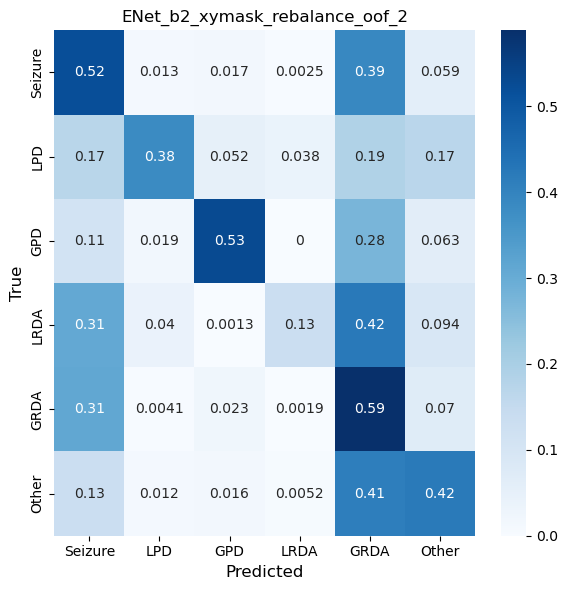

In [13]:
plot_oof = oof_df.copy()

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plot_oof['target_id'], plot_oof['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{ModelConfig.MODEL_NAME}/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
oof_df["kl_loss"].plot(kind='hist', bins=100, title='KL Loss Distribution', figsize=(8, 5))
print(oof_df["kl_loss"].mean())
plt.show()

In [ ]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

plot_oof = oof_df[oof_df['kl_loss'] > 2]

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()

In [ ]:
csv_path = './outputs/ENet_b2_xymasking_remove_less/ENet_b2_xymasking_remove_less_oof_2.csv'

oof_df = pd.read_csv(csv_path)

oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        KL_CRITERION(
            F.log_softmax(
                SOFTMAX(
                    torch.tensor(row[TARGETS_PRED].astype(np.float32)).unsqueeze(0)
                    )
                ), 
            torch.tensor(row[TARGETS].astype(np.float32))
            ).numpy(),
    axis=1)

oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

# y_pred = oof_df[TARGETS_PRED].values.astype(np.float32)
# y_pred_smax = SOFTMAX(torch.tensor(y_pred)).numpy()
# oof_df[TARGETS_PRED] = y_pred_smax

oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
oof_df['target_id'] = oof_df['target'].map(TARGET2ID)

oof_df.head()

In [ ]:
oof_df["kl_loss"].plot(kind='hist', bins=100, title='KL Loss Distribution', figsize=(8, 5))
print(oof_df["kl_loss"].mean())
plt.show()

In [ ]:
KL_CRITERION(
    torch.log(
        SOFTMAX(
            torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32))
            )
        ), 
    torch.tensor(oof_df[TARGETS].values.astype(np.float32))
    ).numpy(),

In [ ]:
plot_oof = oof_df.copy()

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plot_oof['target_id'], plot_oof['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

In [ ]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

plot_oof = oof_df[oof_df['kl_loss'] > 0.2]

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()




In [ ]:
oof_df[oof_df['eeg_id'] == 11127485]

In [ ]:
oof_df[oof_df['eeg_id'].duplicated()] #oof_df.shape #.groupby('eeg_id')['patient_id'].agg(['nunique', 'count']).sort_values(by='count', ascending=False).head(10)

In [ ]:
score_kaggle = oof_df2.loc[:10].apply(lambda row: calc_kaggle_score(row[['eeg_id']+TARGETS], row[['eeg_id']+TARGETS_PRED]), axis=1)
score_kaggle

In [ ]:
submission_df = oof_df2[['eeg_id']+TARGETS_PRED].copy()
submission_df.columns = ['eeg_id'] + TARGETS

solution_df = oof_df2[['eeg_id']+TARGETS].copy()

score_value = kaggle_score(solution_df, submission_df, 'eeg_id')

score_value

In [ ]:
# oof_df1, cv_1 = analyze_oof("./outputs/ENet_b2_xymasking_remove_less/ENet_b2_xymasking_remove_less_oof_1.csv")
# print(cv_1)
# oof_df1.head()